In [1]:
import jax.numpy as np
import dLux.utils as dlu

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120


from matplotlib import colormaps, colors

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files, summarise_files

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    [
        "/Users/louis/Data/JWST/amigo_data/ERS1386/calgrps/",
        "/Users/louis/Data/JWST/amigo_data/COMM1903/calgrps/",
    ],
    "calgrps",
    EXP_TYPE="NIS_AMI",
    FILTER=["F480M", "F430M", "F380M"],
    **kwargs,
)


# Get each star
# TODO: GET TEFFS!!
HD37803_files = file_fn(TARGPROP="HD-37093")  # COMM
HD36805_files = file_fn(TARGPROP="HD-36805")  # COMM
HD116084_files = file_fn(TARGPROP="HD-116084")  # ERS
HD115842_files = file_fn(TARGPROP="HD-115842")  # ERS

# Build data set
files = HD37803_files[:2] + HD36805_files[:2] + HD116084_files[:2] + HD115842_files[:2]

print(f"\n{len(files)}")
summarise_files(
    files,
    [
        "APERNAME",
        "PUPIL",
        "SUBARRAY",
        "DETECTOR",
        "EXP_TYPE",
        "NINTS",
        "NGROUPS",
        "OBSERVTN",
        "VISIT",
        "VISITGRP",
        "SEQ_ID",
        "ACT_ID",
        "EXPOSURE",
    ],
)

dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision

8
  APERNAME: NIS_AMI1
  PUPIL: NRM
  SUBARRAY: SUB80
  DETECTOR: NIS
  EXP_TYPE: NIS_AMI
  NINTS: 65, 10000, 6000, 118, 5500, 61
  NGROUPS: 2, 3, 4, 9, 12
  OBSERVTN: 012, 017, 018, 016, 010, 020
  VISIT: 001
  VISITGRP: 03
  SEQ_ID: 1
  ACT_ID: 03, 02, 04
  EXPOSURE: 3, 14, 1


In [3]:
def key_fn(file):
    head = file[0].header
    return f"{head["TARGPROP"]}_{head["FILTER"]}_{head["OBSERVTN"]}_{head["ACT_ID"]}_{head["EXPOSURE"]}"


# Check for duplicates
names = []
for file in files:
    name = key_fn(file)
    if name in names:
        print(f"Duplicate")
    names.append(name)
    # print(f"  {name}")

In [4]:
file.info()

Filename: /Users/louis/Data/JWST/amigo_data/ERS1386/calgrps/jw01386010001_03103_00001_nis_calgrps.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     226   ()      
  1  SCI           1 ImageHDU        77   (80, 80, 2)   float32   
  2  PIXELDQ       1 ImageHDU        11   (80, 80)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (80, 80, 2, 5500)   uint8   
  4  ERR           1 ImageHDU        10   (80, 80, 2)   float32   
  5  GROUP         1 BinTableHDU     38   20R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  6  INT_TIMES     1 BinTableHDU     24   5500R x 7C   [J, D, D, D, D, D, D]   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [9108B]   


In [5]:
# for file in files:
#     print(file[0].header["FILTER"])
#     print(file[0].header["NINTS"])
#     plt.imshow(file['SCI'].data[-1])
#     plt.colorbar()
#     plt.show()

In [6]:
# from jax import vmap

# def least_sq(x, y):
#     A = np.vstack([x, np.ones(len(x))]).T
#     m, b = np.linalg.lstsq(A, y, rcond=None)[0]
#     return m, b

# def fit_slope(y):
#     return least_sq(np.arange(len(y)) + 1, y)

# def slope_im(im):
#     ms, bs = vmap(fit_slope)(im.reshape(len(im), -1).T)
#     return ms.reshape(im.shape[1:]), bs.reshape(im.shape[1:])


# for file in files:
#     print(file[0].header["FILTER"])
#     print(file[0].header["NINTS"])
#     dq = np.asarray(file["PIXELDQ"].data > 0, bool)
#     data = np.asarray(file["SCI"].data, float)
#     dilated_dq = convert_adjacent_to_true(dq)
#     dq_edges = dilated_dq & ~dq
#     dq_edge_inds = np.where(dq_edges)
#     dq_edge_ramps = data[:, *dq_edge_inds].T
#     # print(dq_edge_ramps.shape)
#     ms, bs = vmap(fit_slope)(dq_edge_ramps)
#     xs = np.arange(dq_edge_ramps.shape[1]) + 1
#     # ys = ms * xs[:, None] + bs
#     plt.figure(figsize=(15, 4))
#     plt.subplot(1, 2, 1)
#     plt.hist(ms, bins = 100)
#     plt.yscale('log')
    
#     plt.subplot(1, 2, 2)
#     plt.hist(bs, bins = 100)
#     plt.yscale('log')
#     plt.show()
#     # print(np.sum(ms < 0) / len(ms))
#     # print(np.sum(ms < 1) / len(ms))
#     # print()
#     # plt.hist(ms, bins=100)
#     # plt.show()
#     # for dq_edge_ramp in dq_edge_ramps:
#     #     plt.plot(dq_edge_ramp)
#     # plt.show()

In [7]:
from jax import vmap
from amigo.stats import check_symmetric, check_positive_semi_definite, build_covariance_matrix
from amigo.misc import full_to_SUB80, estimate_psf_and_bias, convert_adjacent_to_true, fit_slope
from amigo.core import Exposure

def prep_exposure(file, read_noise, key_fn, ms_thresh=0.):
    key = key_fn(file)
    filter = file[0].header["FILTER"]
    star = file[0].header["TARGPROP"]
    nints = file[0].header["NINTS"]
    ngroups = file[0].header["NGROUPS"]

    ramp = np.asarray(file["SCI"].data, float)    
    err = np.asarray(file["ERR"].data, float)
    dq = np.asarray(file["PIXELDQ"].data > 0, bool)
    cov = build_covariance_matrix(err, read_noise=read_noise, min_value=True)

    # Check for bad pixels around dq'd pixels
    # TODO: Check for large biases too? Only calc ms, bs from the first part of the ramp
    # to avoid BFE giving large biases?
    dilated_dq = convert_adjacent_to_true(dq)
    dq_edges = dilated_dq & ~dq
    dq_edge_inds = np.array(np.where(dq_edges))
    dq_edge_ramps = ramp[:, *dq_edge_inds].T
    ms, bs = vmap(fit_slope)(dq_edge_ramps)
    for i in range(len(dq_edge_ramps)):
        if ms[i] <= ms_thresh:
            dq = dq.at[*dq_edge_inds[:, i]].set(True)
        if bs[i] > 250:
            dq = dq.at[*dq_edge_inds[:, i]].set(True)

    # Set bad rows and cols
    dq = dq.at[:4].set(True)  # Bottom 4 rows are bad
    dq = dq.at[-1].set(True)  # Top row is bad
    dq = dq.at[:, -2:].set(True)  # Right 2 columns are bad
    dq = dq.at[:, 0].set(True)  # Left column is bad

    # Check for symmetry and positive semi-definite
    flat_cov = cov.reshape(ngroups, ngroups, -1)
    is_sym = vmap(check_symmetric, -1)(flat_cov).reshape(80, 80)
    is_psd = vmap(check_positive_semi_definite, -1)(flat_cov).reshape(80, 80)
    supp_mask = is_sym & is_psd & ~np.isnan(ramp.sum(0)) & ~dq

    # Nan the bad pixels
    support = np.where(supp_mask)
    ramp = ramp.at[:, ~supp_mask].set(np.nan)
    cov = cov.at[..., ~supp_mask].set(np.nan)
    return Exposure(ramp, cov, support, nints, filter, star, key)

# Load the read noise
from astropy.io import fits
noise_file = fits.open("/Users/louis/Data/JWST/jwst_niriss_readnoise_0005.fits")
read_noise = full_to_SUB80(np.array(noise_file[1].data))

exposures = [prep_exposure(file, read_noise, key_fn) for file in files]
# exposures = [prep_exposure(file, None, key_fn) for file in files]


In [8]:
# for exp in exposures:
#     plt.imshow(exp.data[-1])
#     plt.colorbar()
#     plt.show()

In [9]:
import jax
import zodiax as zdx
import equinox as eqx
from jax import vmap, Array
from amigo.core import SUB80Ramp, BaseModeller, AMIOptics
from amigo.misc import get_filter, estimate_psf_and_bias
from xara.core import determine_origin
import webbpsf

def initialise_model(
    files, exposures, BFE_model, nwavels=11, pupil_mask=None, Teffs={}, default_Teff=5000
):
    print("Constructing model")

    # # Load the read noise
    # noise_file = fits.open("/Users/louis/Data/JWST/jwst_niriss_readnoise_0005.fits")
    # read_noise = full_to_SUB80(np.array(noise_file[1].data))

    # Load the FF
    ff_file = fits.open("/Users/louis/Data/JWST/jwst_niriss_flat_0277.fits")
    ff = full_to_SUB80(np.array(ff_file[1].data))

    # Get webbpsf optical system
    inst = webbpsf.NIRISS()
    inst.load_wss_opd_by_date(files[0][0].header["DATE-BEG"], verbose=False)
    opd = np.array(inst.get_optical_system().planes[0].opd)
    # TODO: Be more clever here and use hte webbpsf functions to check the before and
    # after WFS measurements and check if all data is within those bounds. Can use a
    # dictionary of the times to check for pre-loaded ones and possibly interpolate
    # between them to the correct time. This may be easier than just loading directly
    # from CRDS.

    # Get dLux optical system
    oversample = 5
    optics = AMIOptics(
        opd=opd, pupil_mask=pupil_mask, oversample=oversample, normalise=True
    )
    detector = SUB80Ramp(FF=ff, SRF=np.ones((oversample, oversample)), downsample=False)

    # Get filters and UV masks
    path = "/Users/louis/Data/JWST/niriss_filters/"
    filters = {}

    for file in files:
        filter = file[0].header["FILTER"]
        if filter in filters.keys():
            continue
        wavels, weights = get_filter(filter, path, nwavels)
        filters[filter] = np.array([wavels, weights])

    # Get the stars:
    for file in files:
        star_name = file[0].header["TARGPROP"]
        if star_name in Teffs.keys():
            continue
        else:
            Teffs[star_name] = default_Teff



    positions = {}
    fluxes = {}
    aberrations = {}
    biases = {}
    OneOnFs = {}

    for exposure in exposures:
        key = exposure.key

        psf, bias = estimate_psf_and_bias(exposure.data)
        origin = np.array(determine_origin(psf, verbose=False))
        origin -= (np.array(psf.shape) - 1) / 2
        pos = origin * optics.psf_pixel_scale * np.array([1, -1])

        positions[key] = pos
        fluxes[key] = psf.sum() * 1.075 # Seems to be under estimated
        aberrations[key] = np.zeros_like(optics.pupil.coefficients)
        OneOnFs[key] = np.zeros((exposure.ngroups, 80, 2))
        biases[key] = bias

    # Build exposure model
    model = BaseModeller(
        {
            "optics": optics,
            "detector": detector,
            "BFE": BFE_model,
            "Teffs": Teffs,
            "filters": filters,
            "positions": positions,
            "fluxes": fluxes,
            "aberrations": aberrations,
            "biases": biases,
            "OneOnFs": OneOnFs,
        }
    )

    return model

In [10]:
import dLux as dl
from amigo.BFE import PolyBFE
from astropy.io import fits
from zodiax.experimental import serialise, deserialise
from tqdm.notebook import tqdm

npix = 100
oversample = 4

BFE = PolyBFE(ksize=5, oversample=1, orders=[1, 2])

model = initialise_model(files, exposures, BFE, nwavels=11)

model = model.set("optics.oversample", oversample)
model = model.set("optics.psf_npixels", npix)
model = model.set("detector.sensitivity.SRF", np.ones((oversample, oversample)))
padded_ff = dlu.resize(model.detector.sensitivity.FF, npix)
model = model.set("detector.sensitivity.FF", padded_ff)

Constructing model


In [11]:
# plt.imshow(model.optics.pupil.eval_basis())
# plt.colorbar()

In [12]:
# from zodiax.experimental import deserialise

# bfe = deserialise(f"files/reference/BFE_5_quadratic.zdx")
# pupil_mask = deserialise(f"files/reference/AMI_mask.zdx")
# params_out = deserialise(f"files/reference/params_out.zdx")

# for param in params_out.keys():
#     if isinstance(params_out[param], dict):
#         for p in params_out[param].keys():
#             if p not in model.get(param).keys():
#                 continue
#             model = model.set(f"{param}.{p}", params_out[param][p][-1])
#     else:
#         model = model.set(param, params_out[param][-1])

# model = model.set("BFE", bfe)
# model = model.set("pupil_mask", pupil_mask)

In [13]:
import equinox as eqx
from amigo.misc import planck
from amigo.stats import total_read_noise
from amigo.detector_layers import model_ramp


def model_fn(self, exposure, to_BFE=False):
    # Get exposure key
    key = exposure.key

    # Get wavelengths and weights
    wavels, filt_weights = self.filters[exposure.filter]
    weights = filt_weights * planck(wavels, self.Teffs[exposure.star])
    weights *= self.fluxes[key] / weights.sum()

    # Apply correct aberrations
    optics = self.optics.set("coefficients", self.aberrations[key])

    # Make sure this has correct position units and get wavefronts
    pos_rad = dlu.arcsec2rad(self.positions[key])
    PSF = optics.propagate(wavels, pos_rad, weights, return_psf=True)

    # Apply the detector model and turn it into a ramp
    psf = self.detector.model(PSF)
    ramp = model_ramp(psf, exposure.ngroups)
    if to_BFE:
        return ramp

    # Now apply the CNN BFE and downsample
    ramp = eqx.filter_vmap(self.BFE.apply_array)(ramp)
    ramp = vmap(dlu.resize, (0, None))(ramp, 80)

    # Apply bias and one of F correction
    ramp += total_read_noise(self.biases[key], self.OneOnFs[key])
    return ramp

(28, 28)
(28, 28)
(28, 28)


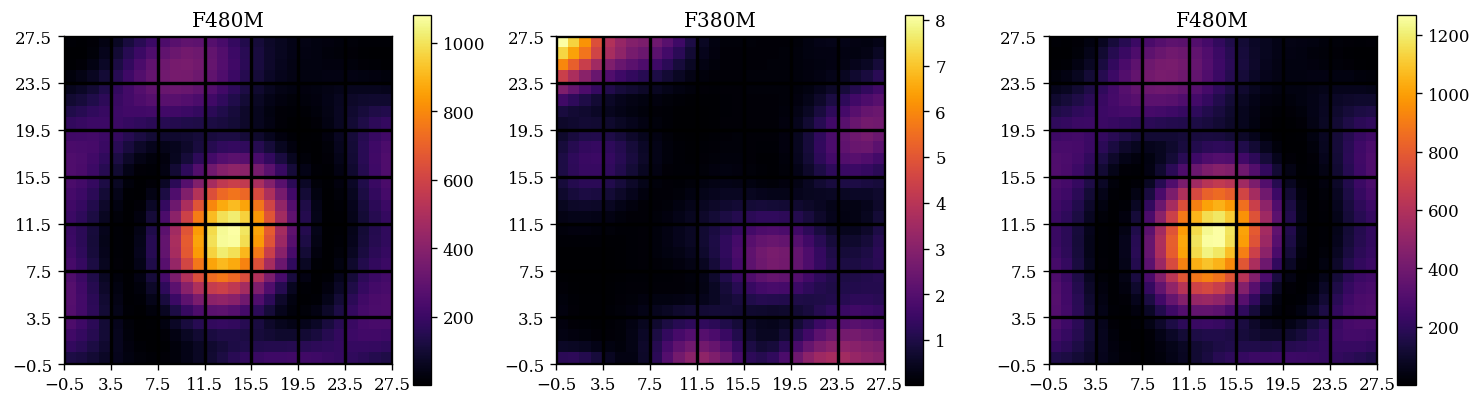

In [14]:
ramps = [model_fn(model, exp, to_BFE=True) for exp in exposures]

import matplotlib.ticker as ticker

plt.figure(figsize=(15, 4))

for i, ramp in enumerate(ramps[:3]):
    im = ramp[-1]

    n = 7  # n 'true' pixels
    oversample = model.optics.oversample  # oversample for each 'true' pixel
    c = im.shape[-1] // 2
    s = (n * oversample) // 2
    x = 5 * oversample
    y = 0 * oversample

    if oversample % 2 == 0:
        im_slice = im[c - s + y : c + s + y, c - s + x : c + s + x]
    else:
        im_slice = im[c - s + y : c + s + y + 1, c - s + x : c + s + x + 1]
    print(im_slice.shape)

    ax = plt.subplot(1, 3, i + 1)
    plt.title(exposures[i].filter)
    plt.imshow(im_slice)
    plt.colorbar()
    ax.xaxis.set_major_locator(ticker.LinearLocator(n + 1))
    ax.yaxis.set_major_locator(ticker.LinearLocator(n + 1))
    ax.grid(color="black", linewidth=2)

plt.show()

In [15]:
from amigo.CNN import Expand, Squeeze, Downsample
from typing import List, Callable

class ConvBFE(eqx.Module):
    """
    A CNN To calculate the charge bleeding.

    Output should be normalised such that the sum is zero, ie conserve charge.

    Norm fact is the value that everything is scaled by at the input/output of the
    network. This keeps the network values in a reasonable range, and allows for the
    inputs/outputs to be in the same range as the input data. This will need to be
    larger for deeper well depth data.
    """

    layers: List[Callable]
    oversample: int = eqx.field(static=True)
    pad: int = eqx.field(static=True)

    def __init__(self, convs, oversample, pad, key):
        subkeys = jr.split(key, len(convs) + 1)

        layers = []

        for conv, subkey in zip(convs, subkeys[1:]):
            try:
                layers.append(conv(subkey))                
            except:
                layers.append(conv)
            layers.append(jax.nn.relu)
        layers[-1] = lambda x: x
        layers.append(Squeeze())
        # layers.append(Downsample(oversample))

        self.layers = layers
        self.oversample = oversample
        self.pad = pad

    @property
    def field_of_regard(self):
        return calc_rfield(self.layers)

    def image_to_grads(self, image):
        ygrads, xgrads = np.gradient(image)
        yygrads = np.gradient(ygrads)[0]
        xxgrads = np.gradient(xgrads)[1]
        output = np.array([xgrads, ygrads, xxgrads, yygrads])
        return output / np.array([1e2, 1e2, 1e2, 1e2])[:, None, None]

    def __call__(self, image):
        # Re add back to the original image
        initial_charge = dlu.downsample(image, self.oversample, mean=False)
        # return initial_charge

        x = self.image_to_grads(image)
        for layer in self.layers:
            x = layer(x)
        # bleeding = np.squeeze(x) * 5e4
        bleeding = np.squeeze(x) * 1e3
        
        k = self.pad

        cent_bleed = bleeding[k:-k, k:-k]
        bleeding -= cent_bleed.mean()
        return initial_charge + bleeding

    def apply_array(self, x):
        """This only exists to match PolyBFE methods"""
        return self(x)


In [16]:
import jax
import jax.random as jr
import jax.tree_util as jtu
from amigo.CNN import calc_rfield


kernel_size = 3
oversample = model.optics.oversample
N = kernel_size * oversample

def Conv(in_size=1, out_size=1, stride=1, dilate=1, pad=1, **kwargs):
    return (
        lambda key: eqx.nn.Conv2d(
            in_channels=in_size, 
            out_channels=out_size, 
            stride=2*(stride,), 
            dilation=2*(dilate,), 
            padding=pad, 
            kernel_size=kernel_size, 
            key=key, 
            **kwargs,
        )
    )

halve = vmap(Downsample(2))
convs = [
    Conv(in_size=4, out_size=32, stride=1, pad=1),
    # Conv(in_size=64, out_size=64, stride=1, pad=1),
    # eqx.nn.AvgPool2d(kernel_size=2, stride=2),
    # eqx.nn.MaxPool2d(kernel_size=2, stride=2),
    halve,
    Conv(in_size=32, out_size=16, stride=1, pad=1),
    # Conv(in_size=32, out_size=32, stride=1, pad=1),
    # eqx.nn.AvgPool2d(kernel_size=2, stride=2),
    # eqx.nn.MaxPool2d(kernel_size=2, stride=2),
    halve,
    Conv(in_size=16, out_size=8, stride=1, pad=1),
    # Conv(in_size=16, out_size=16, stride=1, pad=1),
    Conv(in_size=8, out_size=4, stride=1, pad=1),
    # Conv(in_size=8, out_size=8, stride=1, pad=1),
    Conv(in_size=4, out_size=1, stride=1, pad=1),
]

pad = (model.optics.psf_npixels - 80) // 2
convBFE = ConvBFE(convs, oversample, pad=pad, key=jr.PRNGKey(0))
print(f"Field of Regard: {convBFE.field_of_regard}")

# # Make output small initially
leaves, static = eqx.partition(convBFE, eqx.is_array)
small_leaves = jtu.tree_map(lambda x: 0.5 * x, leaves, is_leaf=eqx.is_array)
small_BFE = eqx.combine(small_leaves, static)

# # Set the model
# # model = model.set("BFE", convBFE)
# model = model.set("BFE", small_BFE)


x = convBFE.image_to_grads(ramps[0][0])
print(f" -> {x.shape}")
for layer in convBFE.layers:
    x = layer(x)
    if isinstance(layer, (eqx.nn.Conv, eqx.nn.Pool, Squeeze, Expand, Downsample)):
        print(str(type(layer)).split(".")[-1][:-2])
        print(f" -> {x.shape}")

Field of Regard: 11
 -> (4, 400, 400)
Conv2d
 -> (32, 400, 400)
Conv2d
 -> (16, 200, 200)
Conv2d
 -> (8, 100, 100)
Conv2d
 -> (4, 100, 100)
Conv2d
 -> (1, 100, 100)
Squeeze
 -> (100, 100)


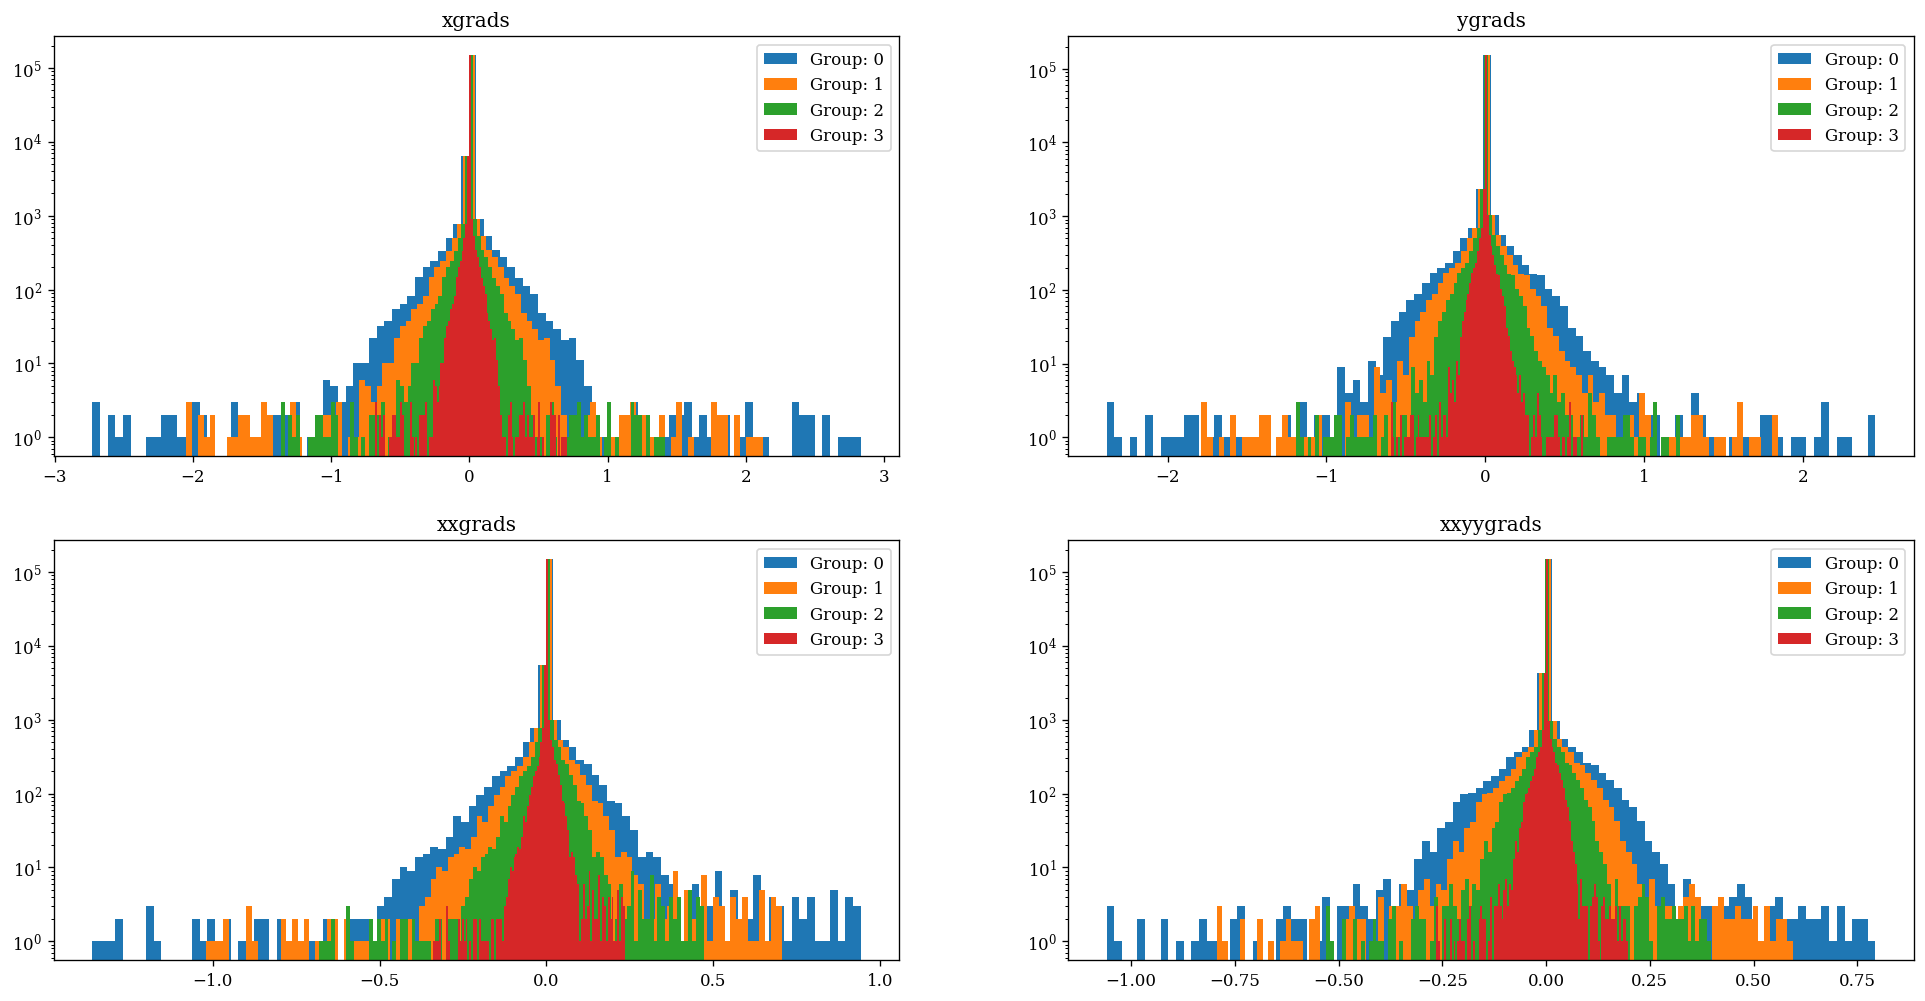

In [17]:
ramp = ramps[1]

fig = plt.figure(figsize=(20, 10))
axes = fig.subplots(2, 2).flatten()
for i, im in enumerate(np.flip(ramp, 0)):
    out = convBFE.image_to_grads(im)
    for ax, vals in zip(axes, out):
        ax.hist(vals.flatten(), bins=100, label=f'Group: {i}')

titles = ["xgrads", "ygrads", "xxgrads", "xxyygrads"]
for ax, title in zip(axes, titles):
    ax.legend()
    ax.set(yscale="log", title=title)

0.0


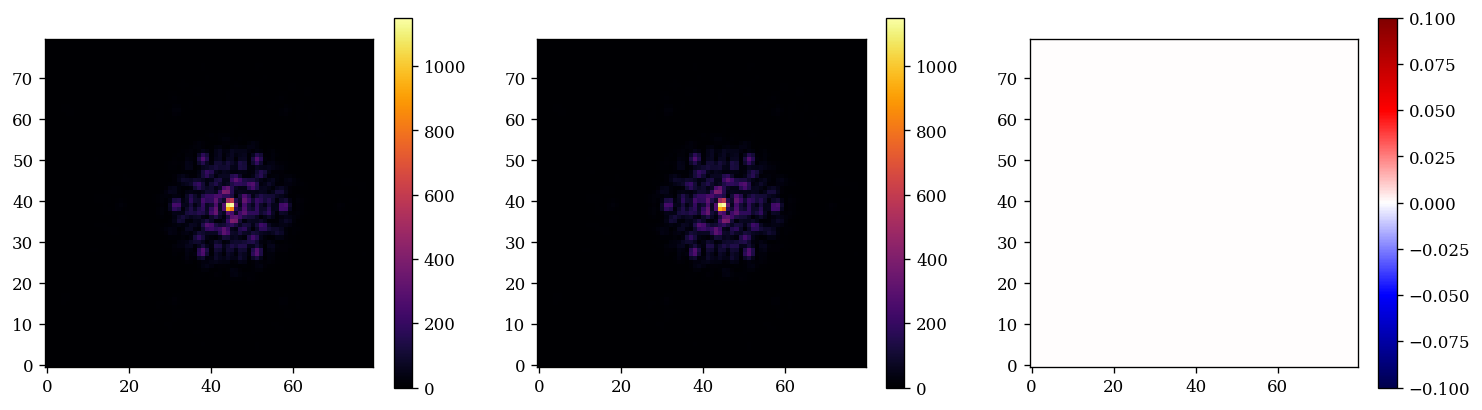

0.0


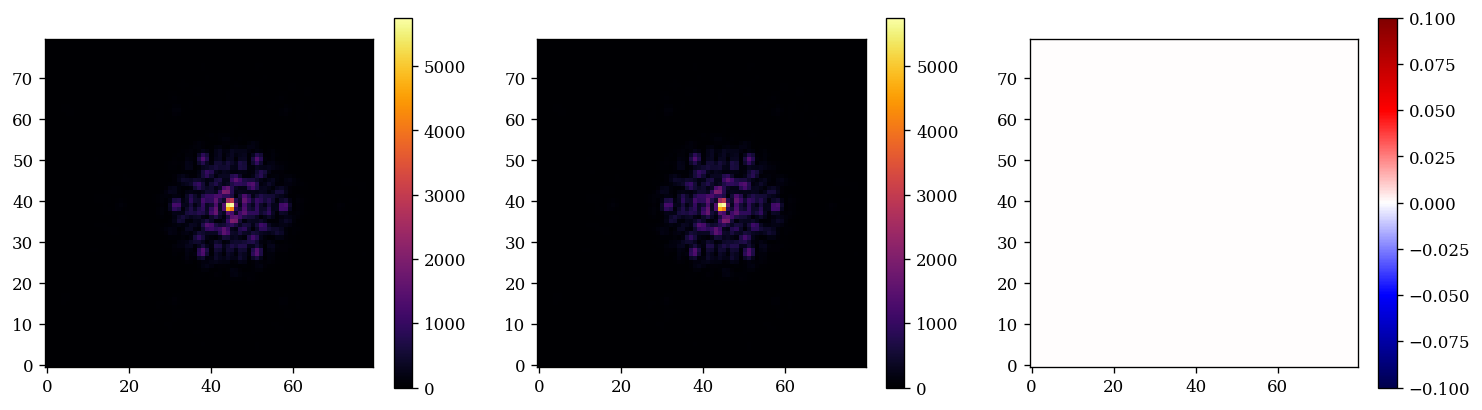

0.0


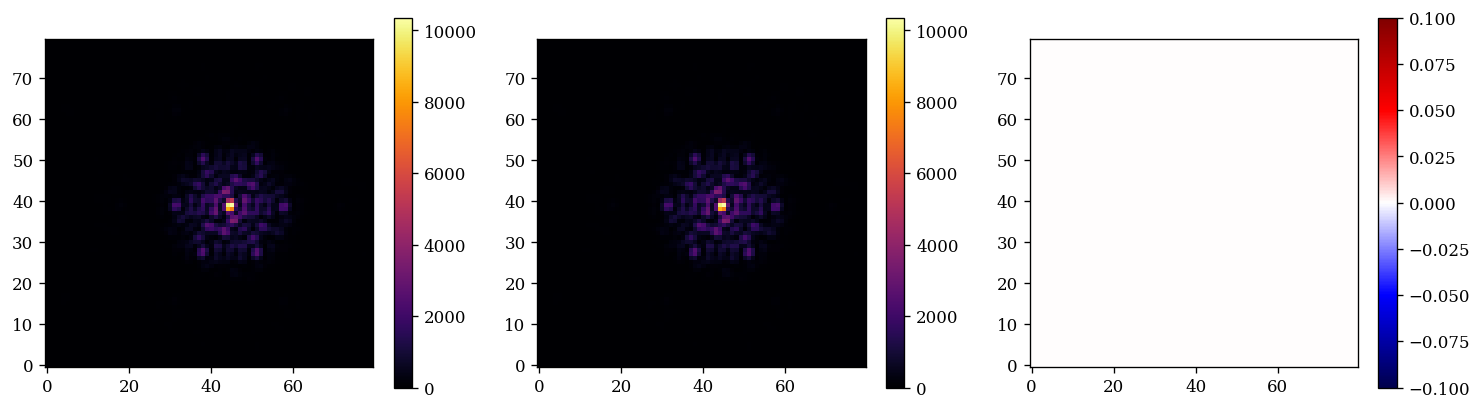

In [18]:
k = convBFE.pad
for full_psf in ramps[0][::4]:

    psf = dlu.downsample(full_psf, oversample, mean=False)[k:-k, k:-k]
    # psf = full_psf[k:-k, k:-k]
    # final = model.BFE(full_psf)[k:-k, k:-k]
    final = model.BFE.apply_array(full_psf)[k:-k, k:-k]
    bleeding = psf - final
    print(bleeding.sum())

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(psf)
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(final)
    plt.colorbar()

    plt.subplot(1, 3, 3)
    v = np.nanmax(np.abs(bleeding))
    plt.imshow(bleeding, cmap=seismic, vmin=-v, vmax=v)
    plt.colorbar()
    plt.show()

In [19]:
import zodiax as zdx
import jax.scipy as jsp
import optax


def log_prior(model, exposure, mean=80, std=50):
    # Estimated std is ~25, so we use 50 here to be conservative
    # Estimated mean is taken from the initial bias estimation
    bias_vec = model.biases[exposure.key][*exposure.support]
    return jsp.stats.norm.logpdf(bias_vec, loc=mean, scale=std).sum()


def posterior(model, exposure, per_pix=True):
    # key = exposure.key
    ramp = model_fn(model, exposure)
    # total_bias = total_read_noise(model.biases[key], model.OneOnFs[key])
    loglike = exposure.loglike_vec(ramp).sum()
    posterior = loglike + log_prior(model, exposure).sum()
    if per_pix:
        return posterior / np.prod(np.array(exposure.data.shape[-2:]))
    return posterior


def loss_fn(model, exposures):
    loss = -np.array([posterior(model, exp) for exp in exposures])
    # jax.debug.print("{x}", x=loss)
    return loss.sum()


def norm_fn(model, args):
    return model.multiply("sensitivity.SRF", 1 / model.sensitivity.SRF.mean())
    

def grad_fn(grads, args, config):
    exposures = args
    global_params = [
        "BFE.linear",
        "BFE.quadratic",
        "sensitivity.SRF",
        "pupil_mask.holes",
        "pupil_mask.f2f",
        "rotation",
        "shear",
        "compression",
    ]
    nints = np.array([exp.nints for exp in exposures]).sum()
    ngroups = np.array([exp.ngroups for exp in exposures]).sum()
    nims = np.array([exp.nints * exp.ngroups for exp in exposures]).sum()

    # Global parameters need to be normalised by the total number of integrations
    params_in = []
    for param in config.keys():
        if param in global_params:
            params_in.append(param)
    grads = grads.multiply(params_in, 1 / nims)

    # Do BFE slightly differently because its a class leaf
    if 'BFE' in config.keys():
        norm_BFE_grads = jtu.tree_map(lambda x: x / nims, grads.BFE)
        grads = grads.set("BFE", norm_BFE_grads)

    # Per exposure params also need to be normalised by the number of integrations per
    # exposure
    per_exposure_params = [
        "positions",
        "fluxes",
        "aberrations",
        "biases",
        "OneOnFs",
    ]

    for param in per_exposure_params:
        for exp in exposures:
            if param in config.keys():
                norm_fact = 1 / (exp.nints * exp.ngroups)
                grads = grads.multiply(f"{param}.{exp.key}", norm_fact)
    return grads

Q: How to deal with _classes_ as leaves in general?
- Automatically tree_map all operations across the 'leaf'?

In [20]:
from amigo.fitting import optimise
import optax

delay = lambda lr, s: optax.piecewise_constant_schedule(lr * 1e-16, {s: 1e16})
clip = lambda optimiser, v: optax.chain(optimiser, optax.clip(v))
sgd = lambda lr: optax.sgd(lr, nesterov=True, momentum=0.5)
adam = lambda lr: optax.adam(lr)

optimisers = {
    "positions": sgd(delay(2e-4, 0)),
    "aberrations": sgd(delay(1e4, 5)),
    # "positions": sgd(delay(2e-4, 0)),
    # "aberrations": sgd(delay(2e4, 5)),
    "fluxes": sgd(delay(5e9, 15)),
    #
    # "BFE": adam(delay(1e-3, 10)),
    "BFE.linear": sgd(delay(1e-3, 10)),
    "BFE.quadratic": sgd(delay(2e-12, 15)),
    #
    "pupil_mask.holes": sgd(delay(1e-2, 20)),
    "pupil_mask.f2f": sgd(delay(5e-4, 25)),
    "rotation": sgd(delay(1e-1, 25)),
    "shear": sgd(delay(2e-4, 25)),
    "compression": sgd(delay(5e-3, 25)),
    #
    # "sensitivity.SRF": sgd(delay(2e-2, 45)),
    # "sensitivity.F": sgd(delay(1e0, 45)),
    #
    "OneOnFs": sgd(delay(1e4, 30)),
    # "biases": clip(sgd(delay(2e5, 60)), 10.0),
}

params = list(optimisers.keys())

# Optimisation
final_model, losses, params_out, opt_state = optimise(
    model,
    exposures,
    loss_fn,
    60,
    optimisers,
    grad_fn=grad_fn,
    norm_fn=norm_fn,
    print_grads=False,
    return_state=True,
)

Step fn compiling...
Compile Time: 0:00:47
Initial Loss: 155,305.00


Loss: 155,305.00, Change: 0.0:   0%|          | 0/59 [00:00<?, ?it/s]

Compile Time: 0:09:56
Final Loss: 1,342.71


**TODO:**
1. **Train model on linear poly BFE**
2. **Train CNN with fixed params**
2. **Jointly train CNN + model**

In [21]:
def plot_params(losses, params_out, format_fn, k=10, l=-1):
    # nparams = len(params_out.keys())
    # nplots = (nparams + 1) // 2

    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.title("Full Loss")
    plt.plot(losses)

    if k >= len(losses):
        k = 0
    last_losses = losses[k:l]
    n = len(last_losses)
    plt.subplot(1, 2, 2)
    plt.title(f"Final {n} Losses")
    plt.plot(np.arange(k, k + n), last_losses)

    plt.tight_layout()
    plt.show()

    params = list(params_out.keys())
    for i in np.arange(0, len(params), 2):
        fig = plt.figure(figsize=(16, 5))
        ax = plt.subplot(1, 2, 1)
        # plt.title(params[i])
        ax = format_fn(params_out, params[i], ax=ax)
        # plt.plot(format_fn(params_out, params[i]))

        ax = plt.subplot(1, 2, 2)
        if i + 1 == len(params):
            plt.tight_layout()
            plt.show()
            break
        # plt.title(params[i + 1])
        # plt.plot(format_fn(params_out, params[i + 1]))
        ax = format_fn(params_out, params[i + 1], ax=ax)

        plt.tight_layout()
        plt.show()


def invert_params(params):
    """Takes in a dictionary of a list of parameters and returns a 2D array of values"""
    vals = []
    for p in params.keys():
        v = np.array(params[p])
        v = v.reshape(v.shape[0], -1)
        vals.append(v)
    vals = np.concatenate(vals, axis=-1)
    return vals


# This is for plotting the fit
def format_fn(params_out, param, ax, alpha=0.75):
    ax.set(title=param, xlabel="Epochs")

    leaf = params_out[param]
    if isinstance(leaf, list):
        arr = np.array(leaf)
    elif param == "stars":
        pass
    else:
        arr = invert_params(leaf)

    if param == "positions":
        arr = arr.reshape(arr.shape[0], -1)
        ax.plot(arr - arr[0])
        ax.set(ylabel="Position (arcsec)")

    elif param == "fluxes":
        arr = arr.reshape(arr.shape[0], -1)
        # ax.plot(arr - arr[0])
        ax.plot(arr / arr[0])
        ax.set(ylabel="Flux (photons)")

    elif "aberrations" in param:
        arr = arr.reshape(arr.shape[0], -1)
        arr -= arr[0]
        ax.plot(arr - arr[0], alpha=0.25)
        ax.set(ylabel="Aberrations (nm)")

    elif "OneOnFs" in param:
        arr = arr.reshape(arr.shape[0], -1)
        ax.plot(arr - arr[0], alpha=0.25)
        ax.set(ylabel="OneOnFs")

    # The dor '.' denotes this from BFE which is conv net
    elif "BFE." in param:
        arr = arr.reshape(len(arr), -1)
        # ax.plot(arr - arr[0], alpha=0.01)
        ax.plot(arr - arr[0], alpha=0.5)
        ax.set(ylabel="BFE Coefficients")

    elif "SRF" in param:
        arr = arr.reshape(len(arr), -1)
        ax.plot(arr)
        ax.set(ylabel="SRF")

    elif "pupil_mask.holes" in param:
        arr = arr.reshape(len(arr), -1)
        arr -= arr[0]
        arr *= 1e3
        ax.plot(arr, alpha=alpha)
        ax.set(ylabel="Pupil Mask Holes (mm)")

    elif "bias" in param:
        arr = arr.reshape(len(arr), -1)
        ax.plot(arr - arr[0], alpha=0.25)
        ax.set(ylabel="Bias")

    elif "PRF" in param:
        ax.plot(arr.reshape(len(arr), -1), alpha=0.25)
        ax.set(ylabel="PRF")

    elif "rotation" in param:
        ax.plot(dlu.rad2deg(arr))
        ax.set(ylabel="Rotation (deg)")

    elif "stars" in param:
        Teffs = []
        for star in leaf.values():
            Teffs.append(np.array([s.Teff for s in star]))
        Teffs = np.array(Teffs).T
        ax.plot(Teffs)
        ax.set(ylabel="Stellar Teff (K)")

    else:
        ax.plot(arr)

    return ax

**Quad poly BFE (5x5) final loss - 1300**

**Conv  BFE final loss - 1550**

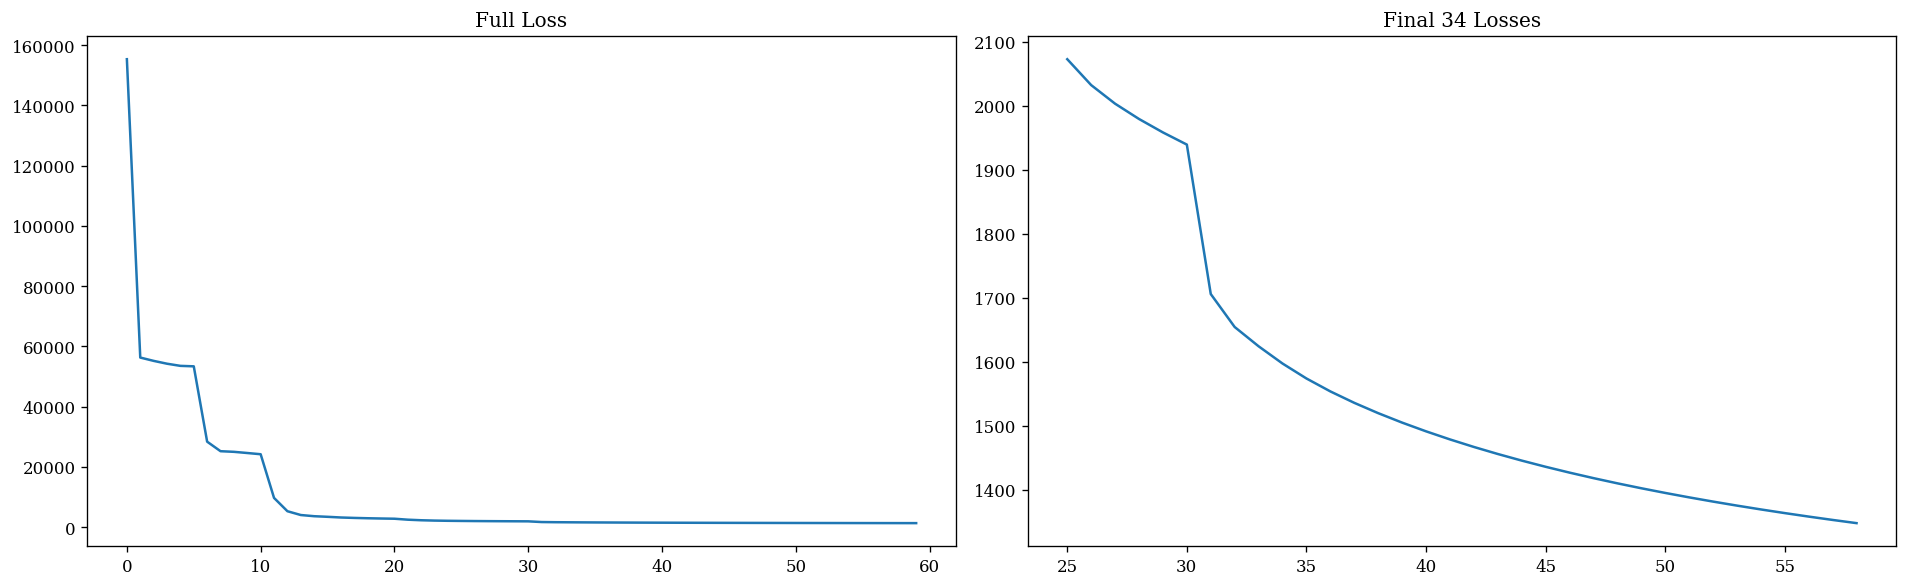

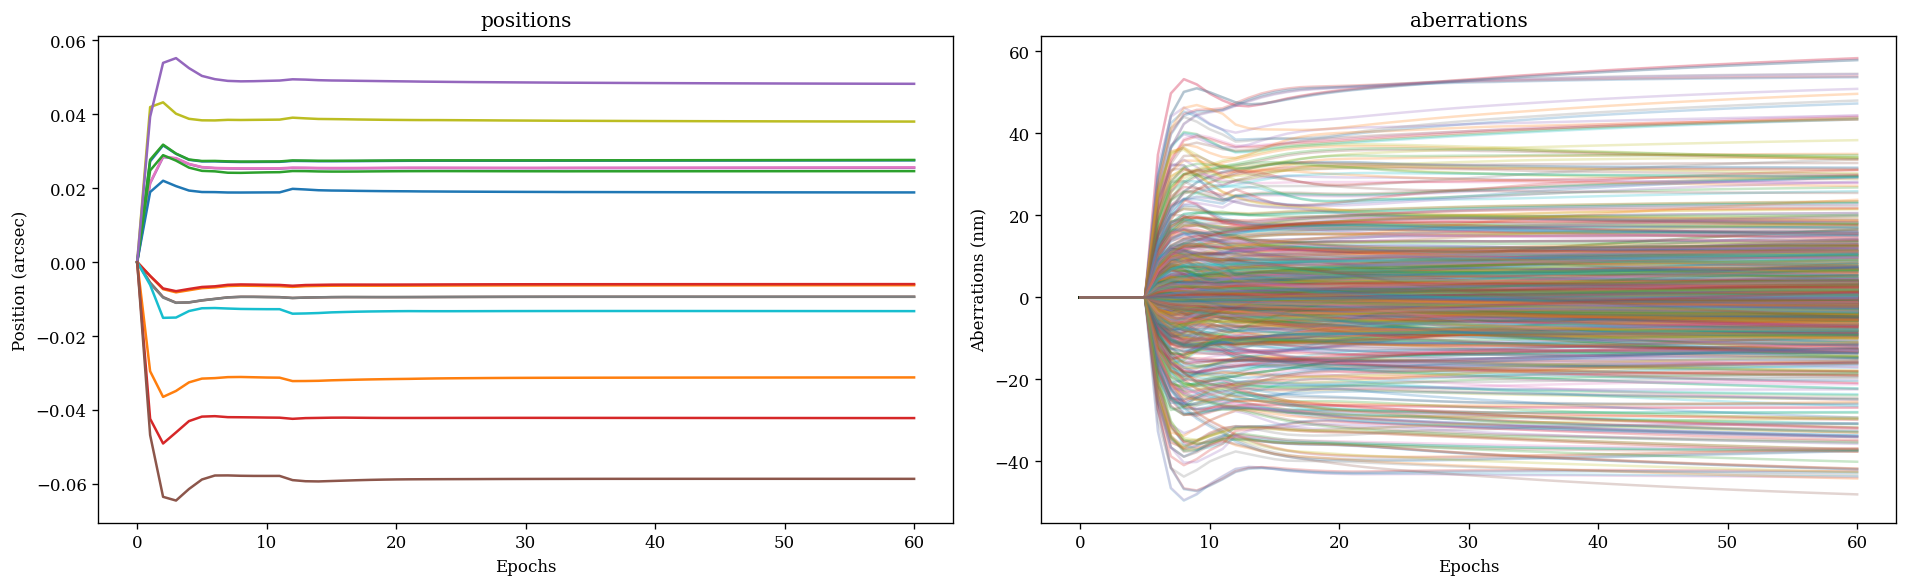

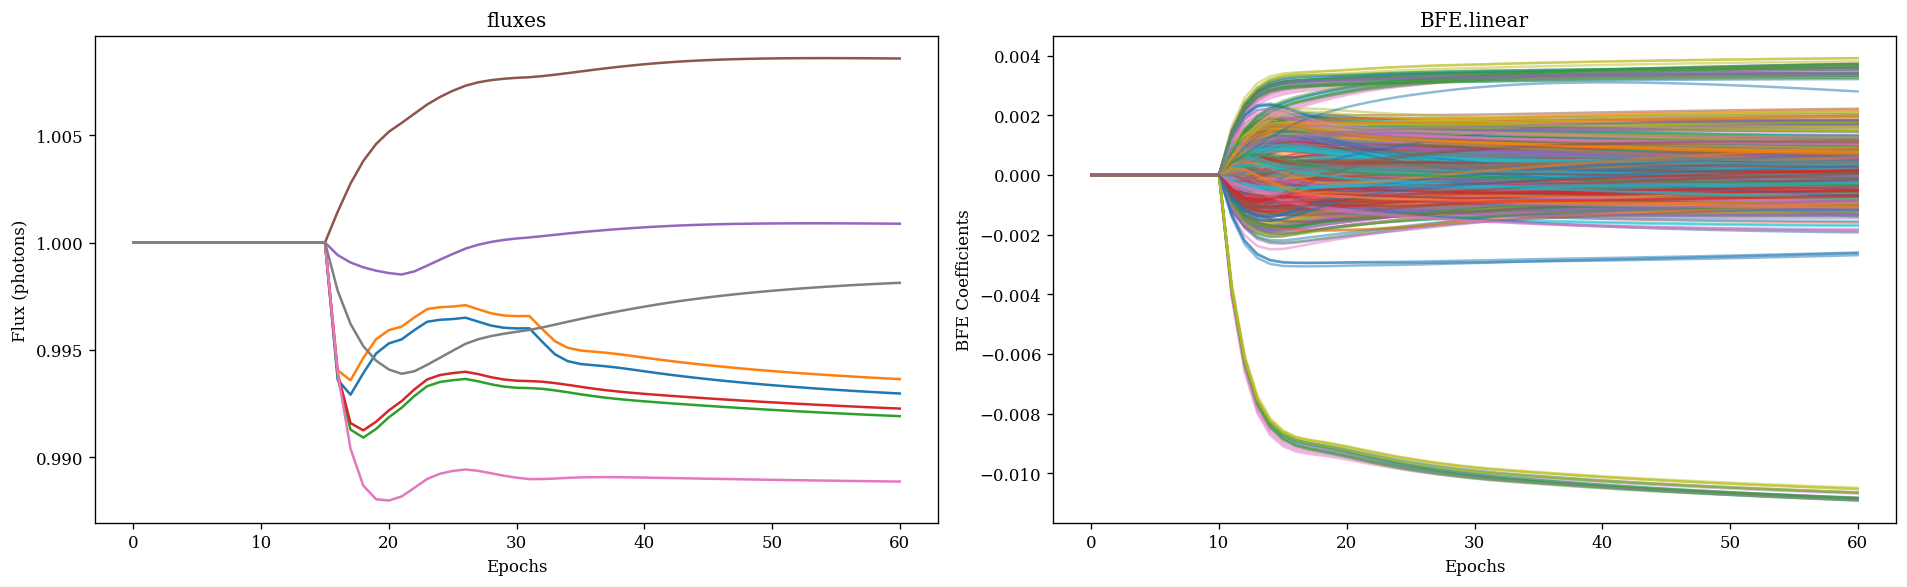

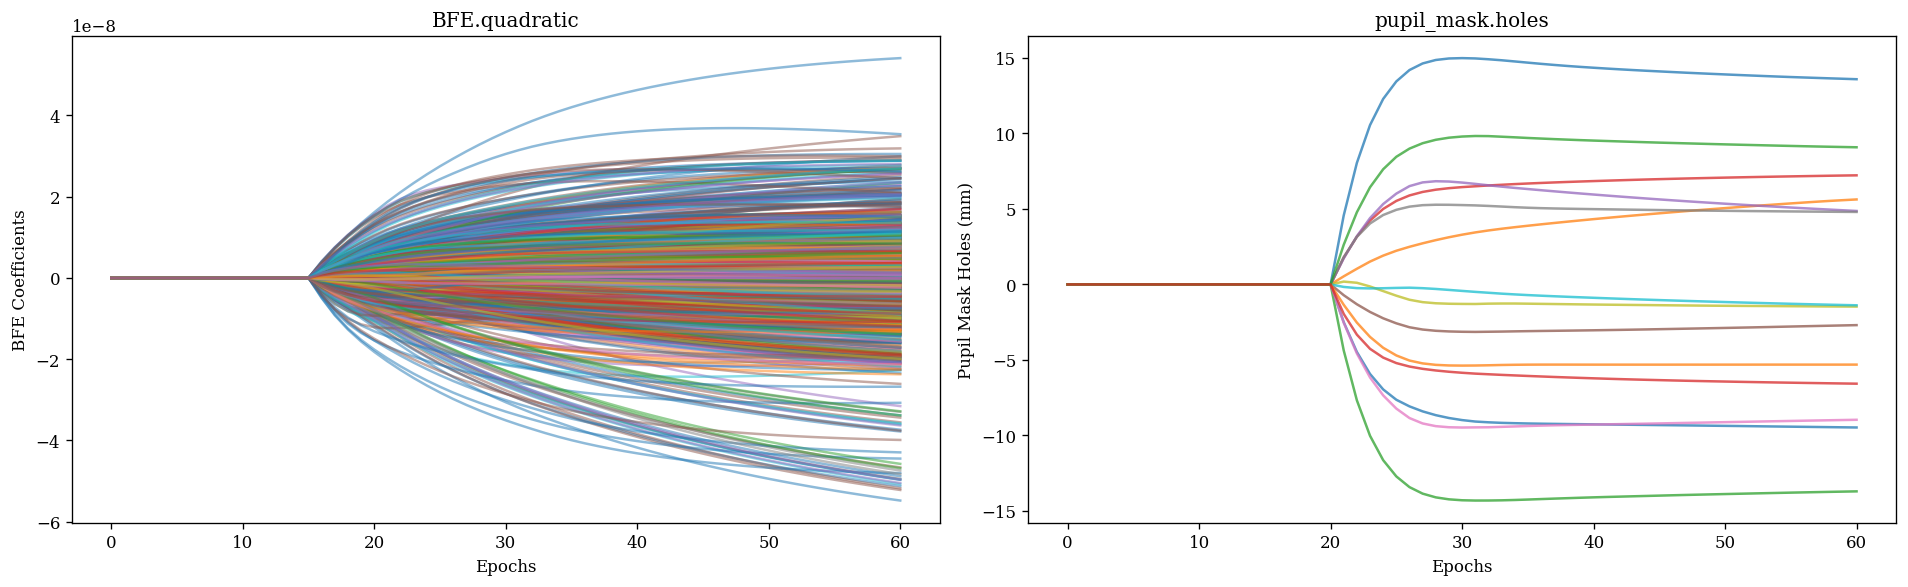

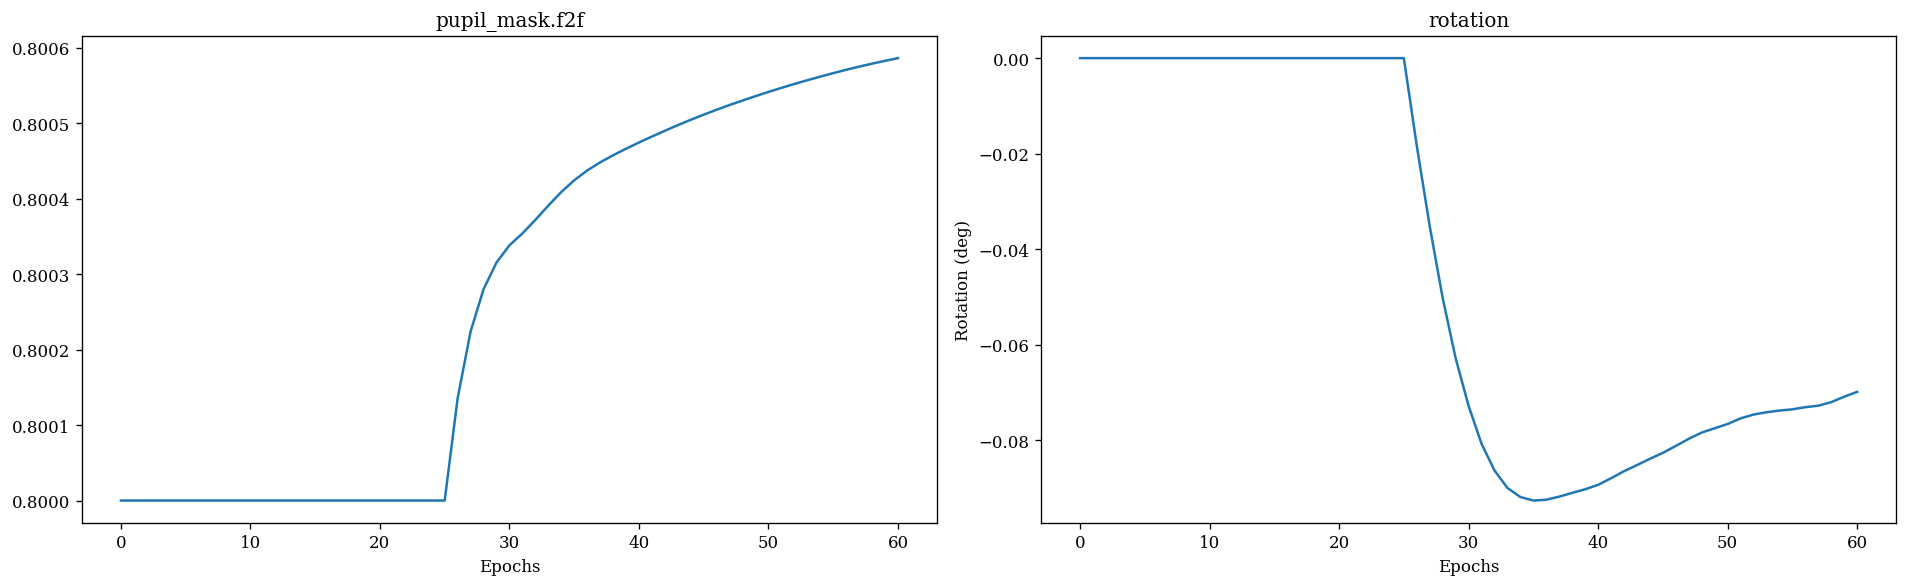

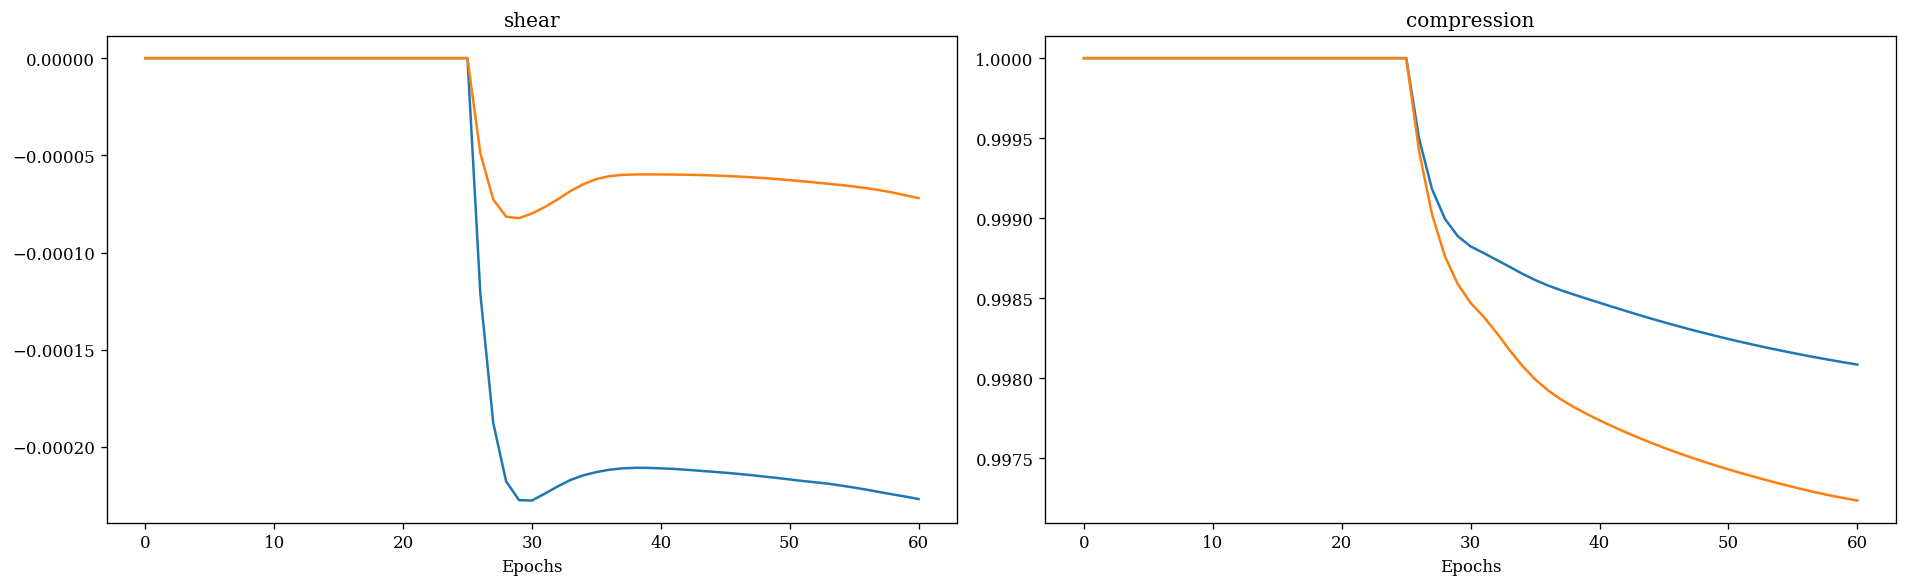

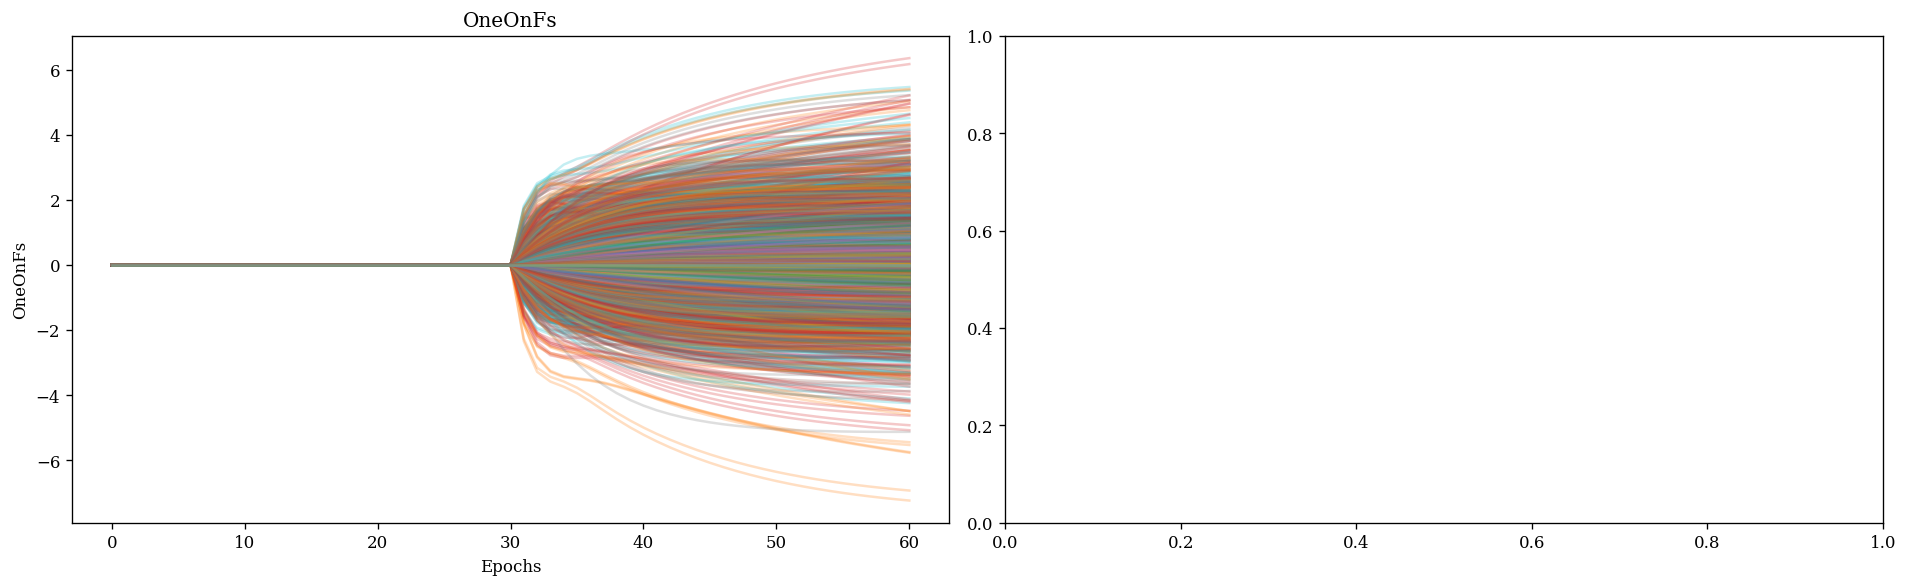

In [22]:
plot_params(np.array(losses), params_out, format_fn, k=25)

In [23]:
def summarise(
    model,
    exposures,
    up_the_ramp=False,
    up_the_ramp_norm=False,
    full_bias=True,
    aberrations=True,
    pow=0.5,
    k=0.5,
    edge_nan=4,
):
    for exp in exposures:
        print(f"Exposure: {exp.key}")
        print(f"Star: {exp.star}")
        print(f"Filter: {exp.filter}")
        print(f"N ints: {exp.nints}")

        nints = exp.nints
        ramp = model_fn(model, exp)
        data = exp.data

        nan_mask = np.where(np.isnan(data))
        ramp = ramp.at[nan_mask].set(np.nan)

        residual = data - ramp
        loglike_im = exp.loglike_im(ramp)
        final_loss = np.nansum(-loglike_im) / np.prod(np.array(data.shape[-2:]))

        total_cov = nints * exp.covariance
        total_residual = nints * residual
        total_err = vmap(vmap(np.diag, -1, -1), -1, -1)(total_cov) ** 0.5
        norm_res_ramp = total_residual / total_err
        norm_res_vec = exp.to_vec(norm_res_ramp)
        norm_res_vec = norm_res_vec[~np.isnan(norm_res_vec)]

        x = np.nanmax(np.abs(norm_res_vec))
        xs = np.linspace(-x, x, 200)
        ys = jsp.stats.norm.pdf(xs)

        vmax = np.maximum(np.nanmax(np.abs(data)), np.nanmax(np.abs(ramp)))
        vmin = np.minimum(np.nanmin(np.abs(data)), np.nanmin(np.abs(ramp)))

        skip = False
        if np.isnan(vmin) or np.isnan(vmax):
            skip = True

        if not skip:
            norm = colors.PowerNorm(gamma=0.5, vmin=-vmin, vmax=vmax)
            inferno.set_bad("k", 0.5)
            seismic.set_bad("k", 0.5)

            plt.figure(figsize=(15, 4))
            plt.subplot(1, 3, 1)
            plt.title(r"Mean Data Ramp $^{}$".format(pow))
            plt.imshow(data.mean(0), cmap=inferno, norm=norm)
            plt.colorbar()

            plt.subplot(1, 3, 2)
            plt.title(f"Mean Model Ramp $^{pow}$")
            plt.imshow(ramp.mean(0), cmap=inferno, norm=norm)
            plt.colorbar()

            plt.subplot(1, 3, 3)
            plt.title(f"Pixel neg log likelihood: {final_loss:,.1f}")
            plt.imshow(-loglike_im, cmap=inferno)
            plt.colorbar()

            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(15, 4))
            ax = plt.subplot(1, 3, 1)
            ax.set_title(f"Noise normalised residual sigma: {norm_res_vec.std():.3}")
            ax.hist(norm_res_vec.flatten(), bins=50, density=True)

            ax2 = ax.twinx()
            ax2.plot(xs, ys, c="k")
            ax2.set_ylim(0)

            ax = plt.subplot(1, 3, 2)
            ax.set_title(f"Noise normalised residual sigma: {norm_res_vec.std():.3}")
            bins = ax.hist(norm_res_vec.flatten(), bins=50)[0]
            ax.semilogy()

            ax2 = ax.twinx()
            ax2.plot(xs, bins.max() * ys, c="k")
            ax2.semilogy()

            v = np.nanmax(np.abs(norm_res_ramp.mean(0)))
            plt.subplot(1, 3, 3)
            plt.title("Mean noise normalised ramp residual")
            plt.imshow(norm_res_ramp.mean(0), vmin=-v, vmax=v, cmap=seismic)
            plt.colorbar()

            plt.tight_layout()
            plt.show()

        if full_bias:
            coeffs = model.OneOnFs[exp.key]
            nan_mask = 1 + (np.nan * np.isnan(data.sum(0)))
            bias = nan_mask * model.biases[exp.key]

            plt.figure(figsize=(15, 4))
            plt.subplot(1, 2, 1)
            plt.title("Pixel Bias")
            plt.imshow(bias, cmap=inferno)
            plt.colorbar()

            plt.subplot(2, 4, (3, 4))
            plt.title("1/f Gradient")
            plt.imshow(coeffs[..., 0])
            plt.colorbar()
            plt.xlabel("x-pixel")
            plt.ylabel("Group")

            plt.subplot(2, 4, (7, 8))
            plt.title("1/f Bias")
            plt.imshow(coeffs[..., 1])
            plt.colorbar()
            plt.xlabel("x-pixel")
            plt.ylabel("Group")

            plt.tight_layout()
            plt.show()

        if aberrations:
            # Get the AMI mask and applied mask
            optics = model.optics.set("coefficients", model.aberrations[exp.key])
            applied_mask = optics.pupil_mask.gen_AMI(optics.wf_npixels, optics.diameter)

            # Get the applied opds in nm and flip to match the mask
            static_opd = np.flipud(optics.pupil.opd) * 1e9
            added_opd = np.flipud(optics.basis_opd) * 1e9
            static_opd = static_opd.at[np.where(~(applied_mask > 1e-6))].set(np.nan)
            added_opd = added_opd.at[np.where(~(applied_mask > 1e-6))].set(np.nan)
            mirror_opd = static_opd + added_opd

            plt.figure(figsize=(15, 8))

            v = np.nanmax(np.abs(static_opd))
            plt.subplot(2, 3, 1)
            plt.title("Static OPD")
            plt.imshow(static_opd, cmap=seismic, vmin=-v, vmax=v)
            plt.colorbar()

            v = np.nanmax(np.abs(added_opd))
            plt.subplot(2, 3, 2)
            plt.title("Added OPD")
            plt.imshow(added_opd, cmap=seismic, vmin=-v, vmax=v)
            plt.colorbar()

            v = np.nanmax(np.abs(mirror_opd))
            plt.subplot(2, 3, 3)
            plt.title("Total OPD")
            plt.imshow(mirror_opd, cmap=seismic, vmin=-v, vmax=v)
            plt.colorbar()

            plt.tight_layout()
            plt.show()

        # plt.figure(figsize=(15, 8))
        # wls = model.wavelengths * 1e6
        # filt_weights = model.filters[list(model.source.keys())[0]]
        # final_weights = model.weights * filt_weights
        # final_weights /= final_weights.sum()

        # plt.subplot(2, 3, 1)
        # plt.title(f"Filter Weights")
        # plt.plot(wls, filt_weights, marker="x")
        # plt.xlabel("Wavelengths (um)")
        # plt.ylabel("Weight")

        # plt.subplot(2, 3, 2)
        # plt.title(f"Spectral Weights")
        # plt.plot(wls, model.weights, marker="x")
        # plt.xlabel("Wavelengths (um)")
        # plt.ylabel("Weight")

        # plt.subplot(2, 3, 3)
        # plt.title(f"Final Weights")
        # plt.plot(wls, final_weights, marker="x")
        # plt.xlabel("Wavelengths (um)")
        # plt.ylabel("Weight")

        # plt.tight_layout()
        # plt.show()

        # plt.figure(figsize=(15, 4))

        # plt.subplot(1, 3, 1)
        # plt.title("Mean Pixel Response Function")
        # v = np.max(np.abs(model.PRF - 1))
        # plt.imshow(model.PRF, vmin=1 - v, vmax=1 + v, cmap=seismic)
        # plt.colorbar()

        # FF = nan_edges(model.FF, 4).at[np.where(model.FF < 0.5)].set(np.nan)

        # plt.subplot(1, 3, 2)
        # plt.title("Flat Field")
        # plt.imshow(FF, vmin=0, vmax=2, cmap=seismic)
        # plt.colorbar()

        # plt.subplot(1, 3, 3)
        # plt.title("Flat Field Histogram")
        # plt.hist(FF.flatten(), bins=100)
        # # plt.xlim(0, 2)
        # plt.show()

        if up_the_ramp:
            plt.figure(figsize=(20, 16))
            plt.suptitle("Up The Ramp Residuals")

            for i in range(exp.ngroups):
                plt.subplot(4, 4, i + 1)
                v = np.nanmax(np.abs(residual[i]))
                plt.imshow(residual[i], cmap=seismic, vmin=-v, vmax=v)
                plt.colorbar()
            plt.show()

        if up_the_ramp_norm:
            plt.figure(figsize=(20, 16))
            plt.suptitle("Up The Ramp Residuals")

            for i in range(exp.ngroups):
                plt.subplot(4, 4, i + 1)
                v = np.nanmax(np.abs(norm_res_ramp[i]))
                plt.imshow(norm_res_ramp[i], cmap=seismic, vmin=-v, vmax=v)
                plt.colorbar()
            plt.show()

Exposure: HD-37093_F480M_017_02_3
Star: HD-37093
Filter: F480M
N ints: 61


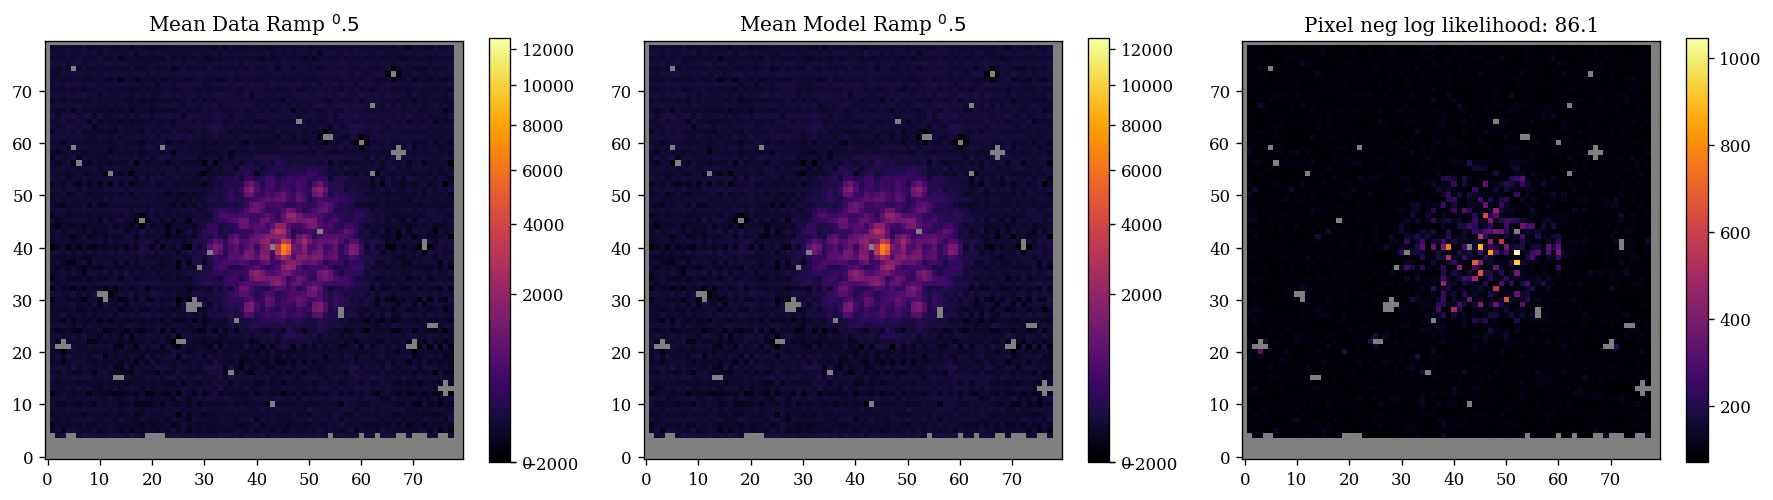

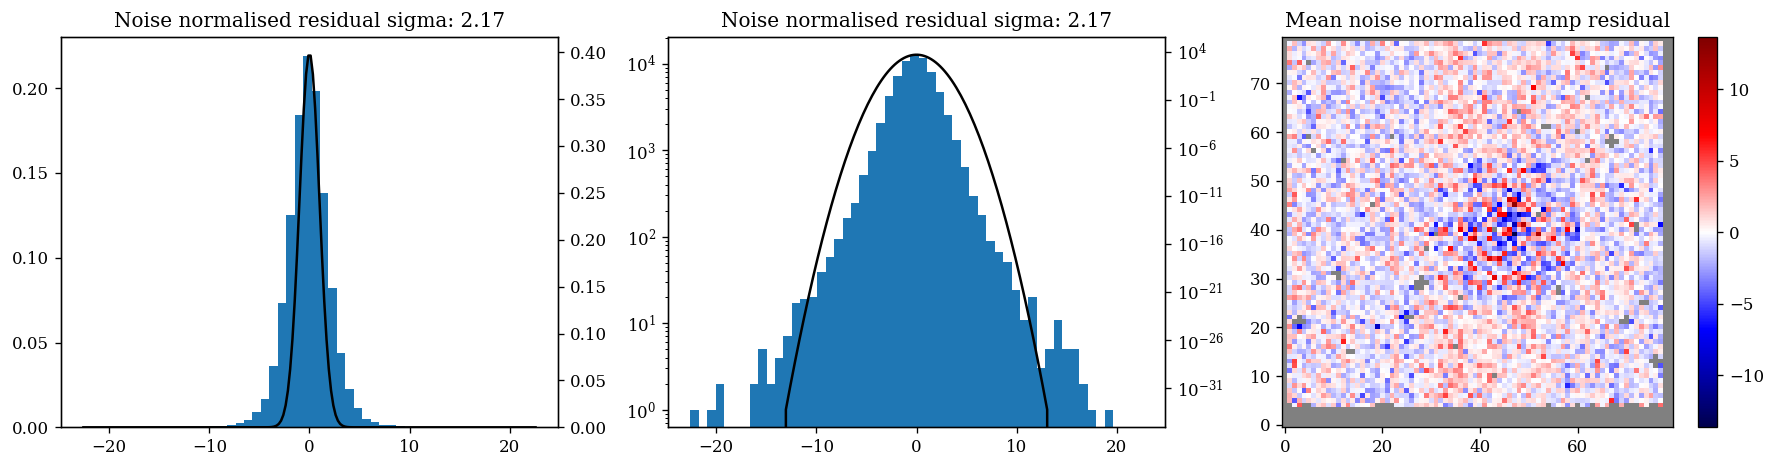

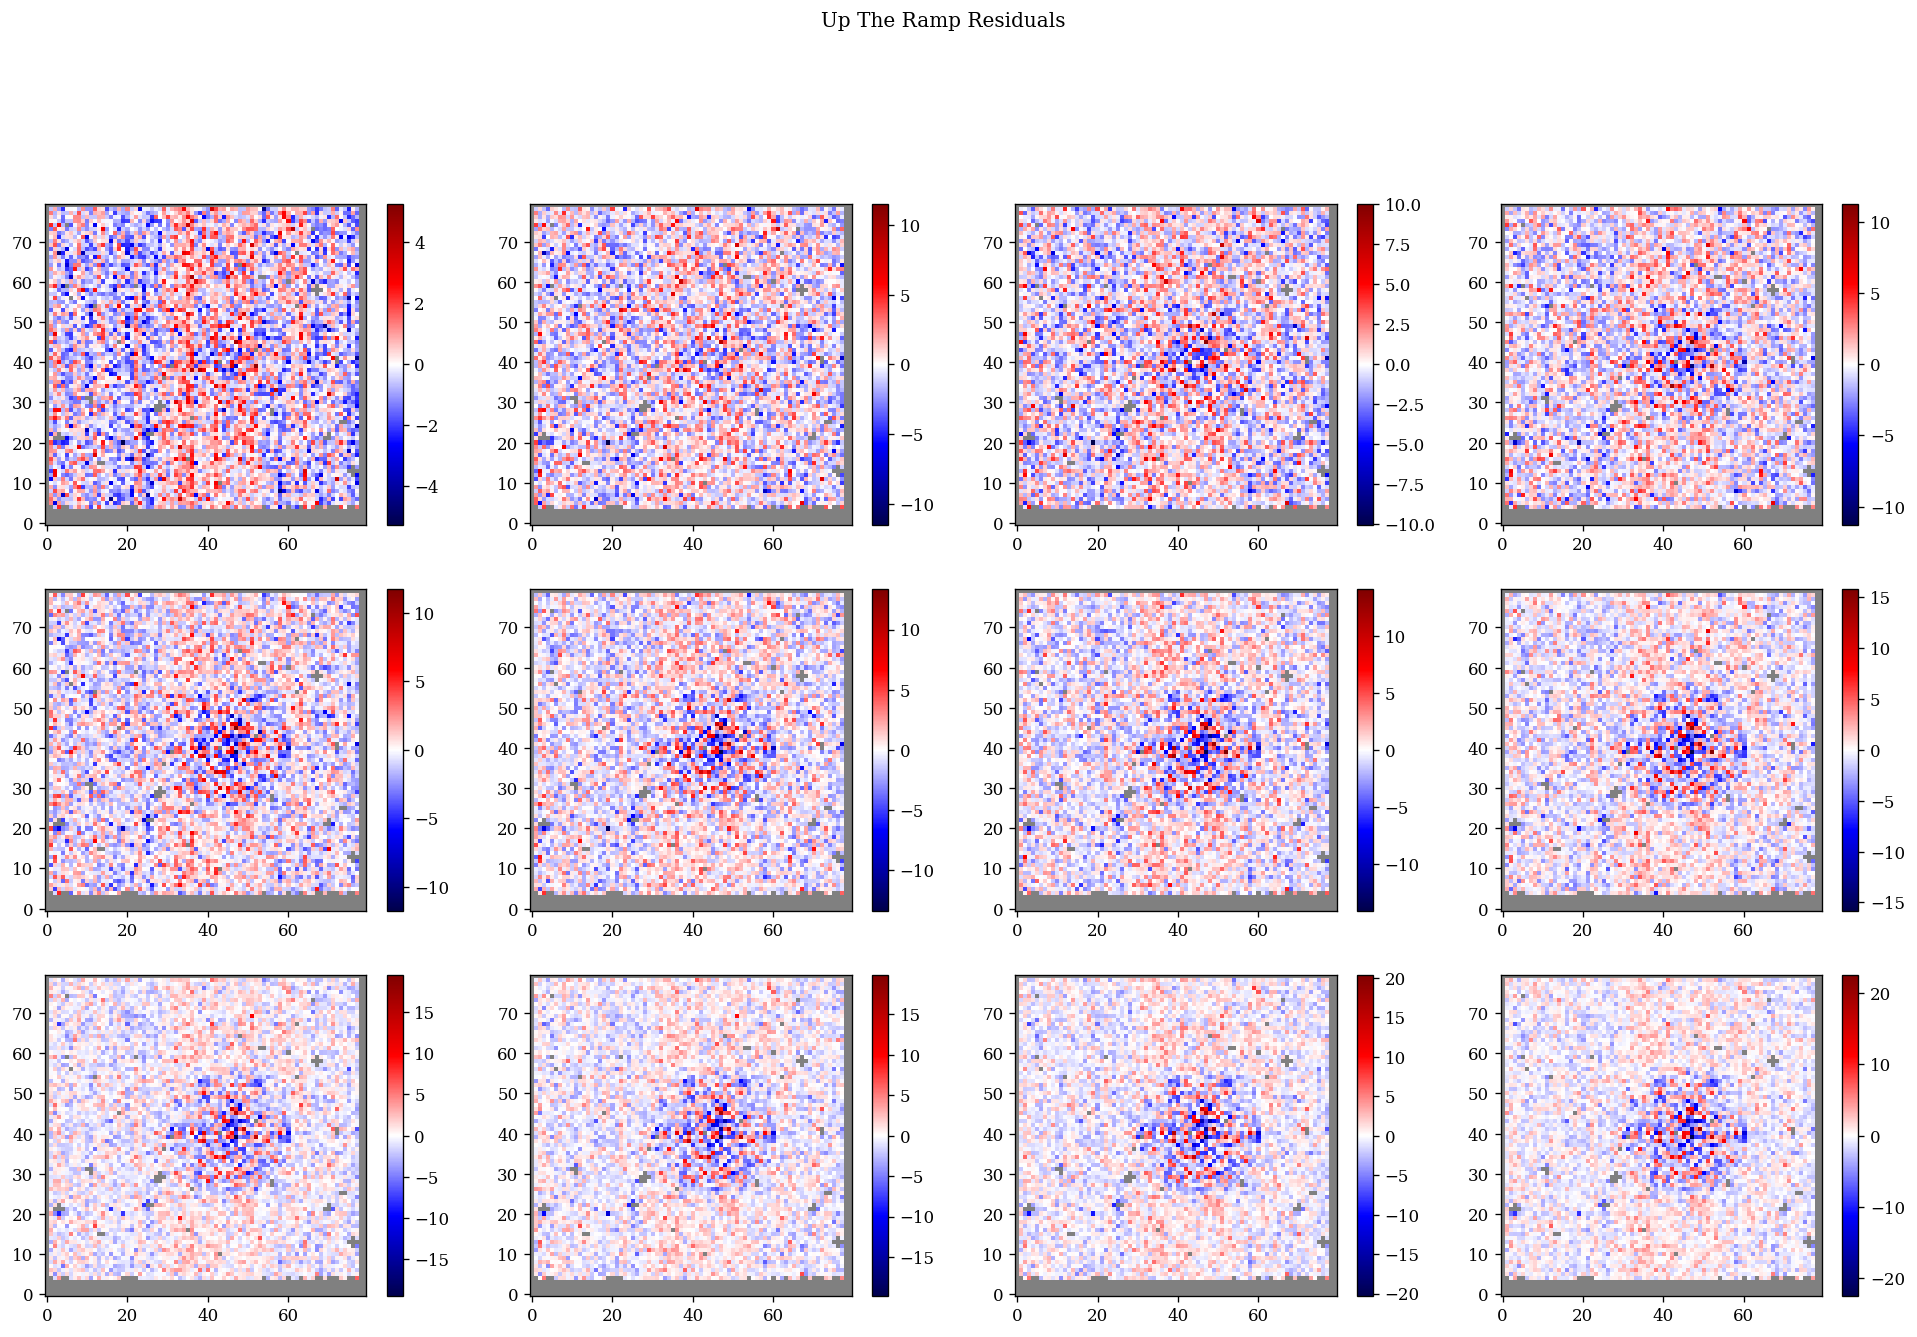

Exposure: HD-37093_F380M_016_04_1
Star: HD-37093
Filter: F380M
N ints: 118


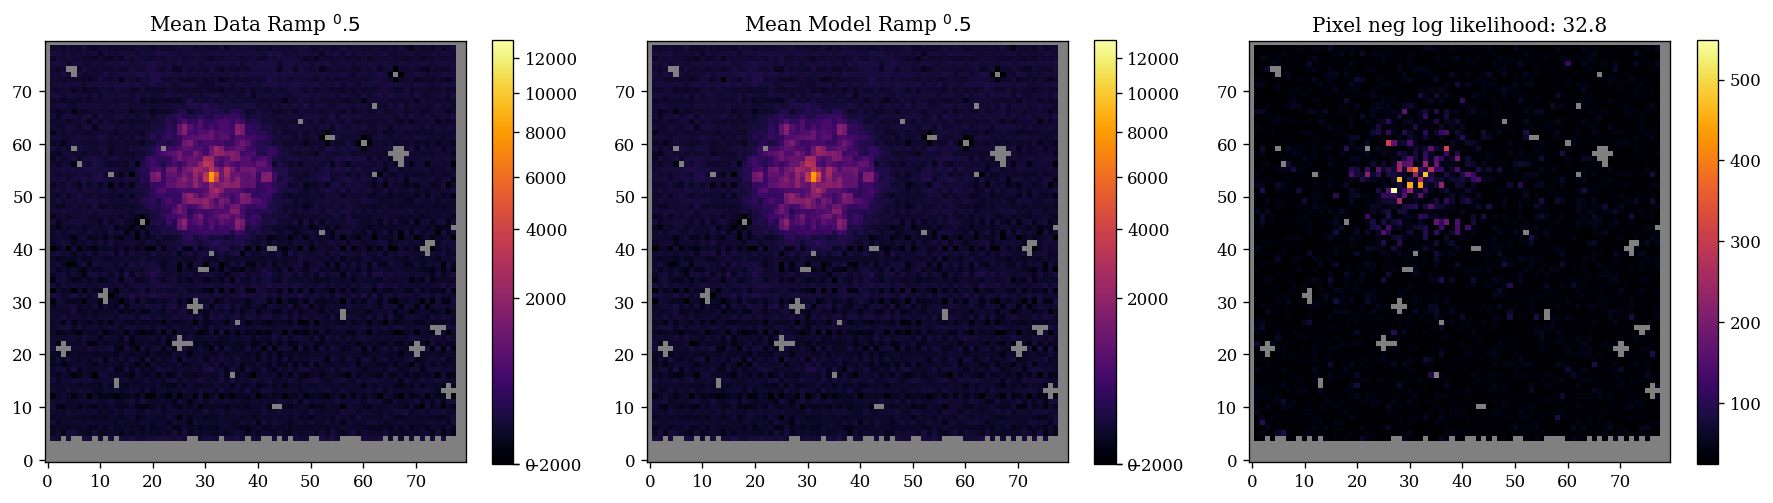

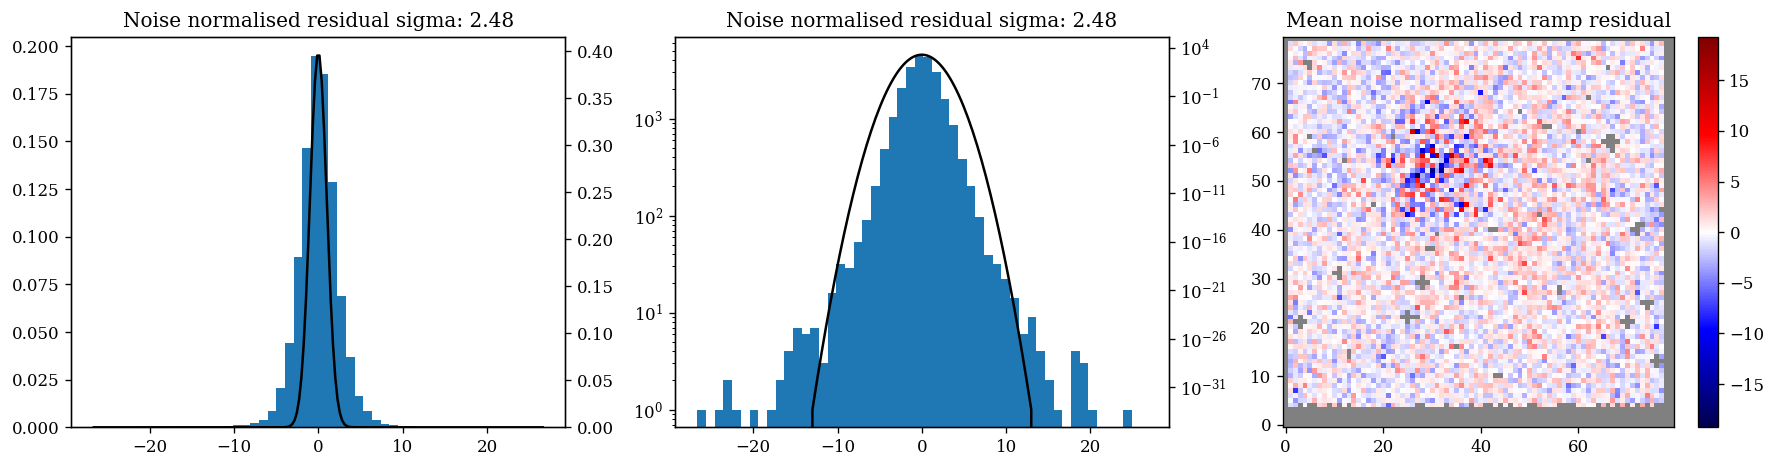

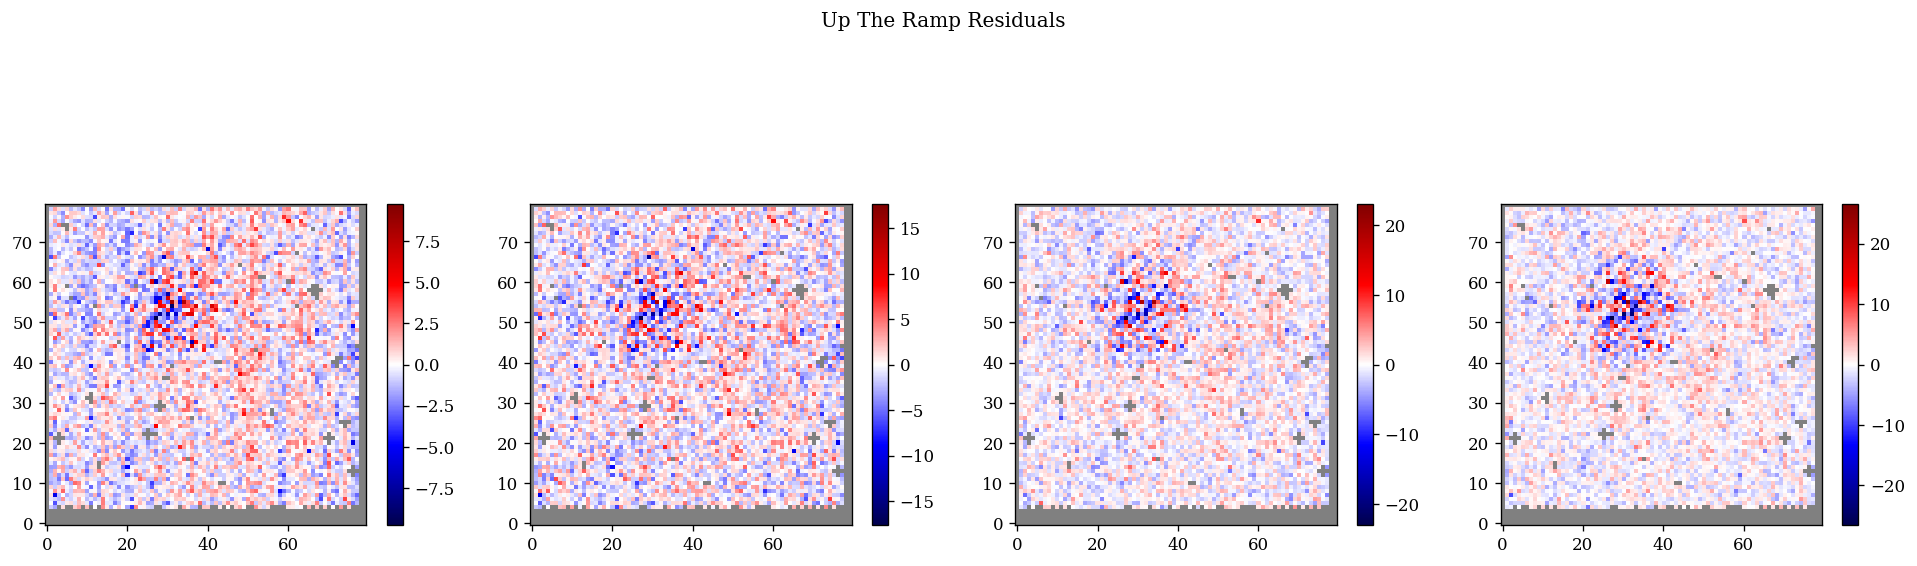

Exposure: HD-36805_F480M_020_02_14
Star: HD-36805
Filter: F480M
N ints: 65


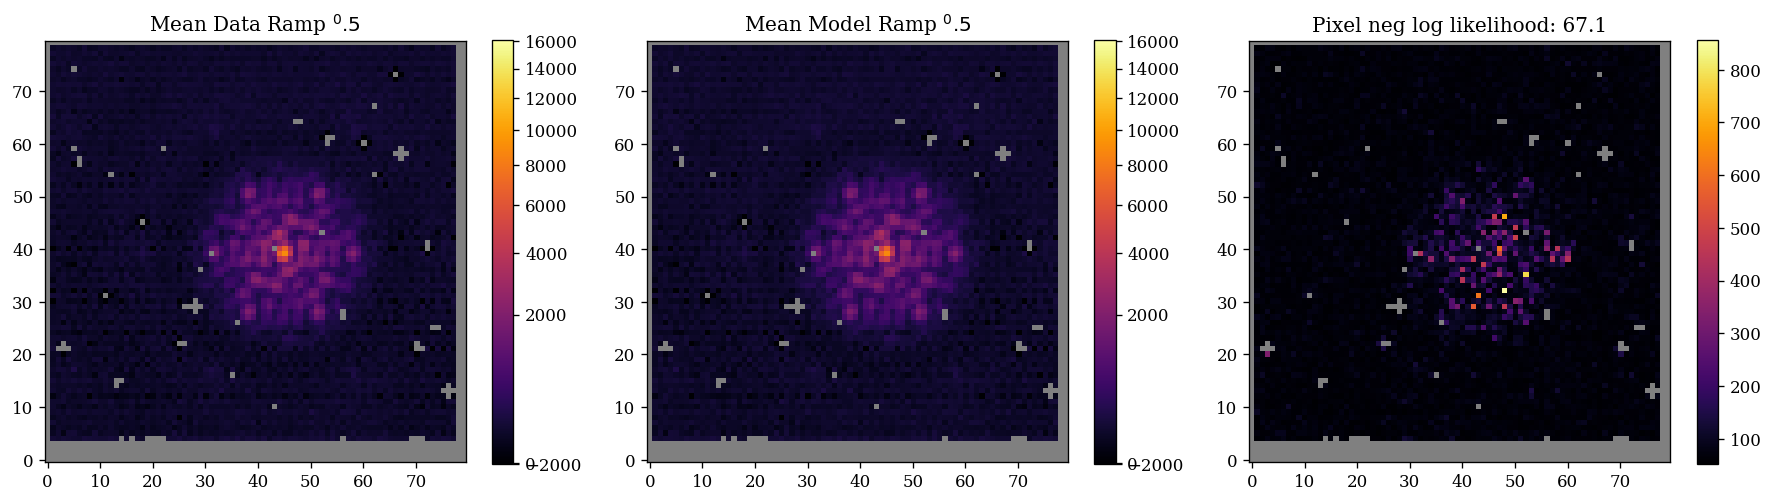

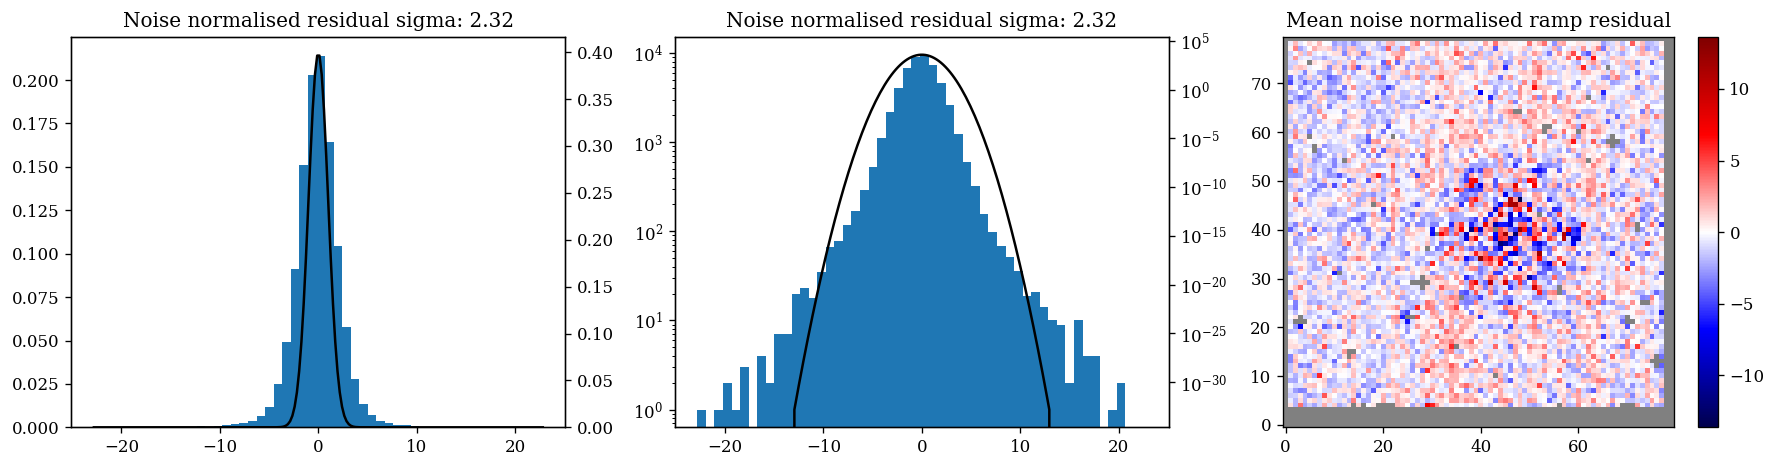

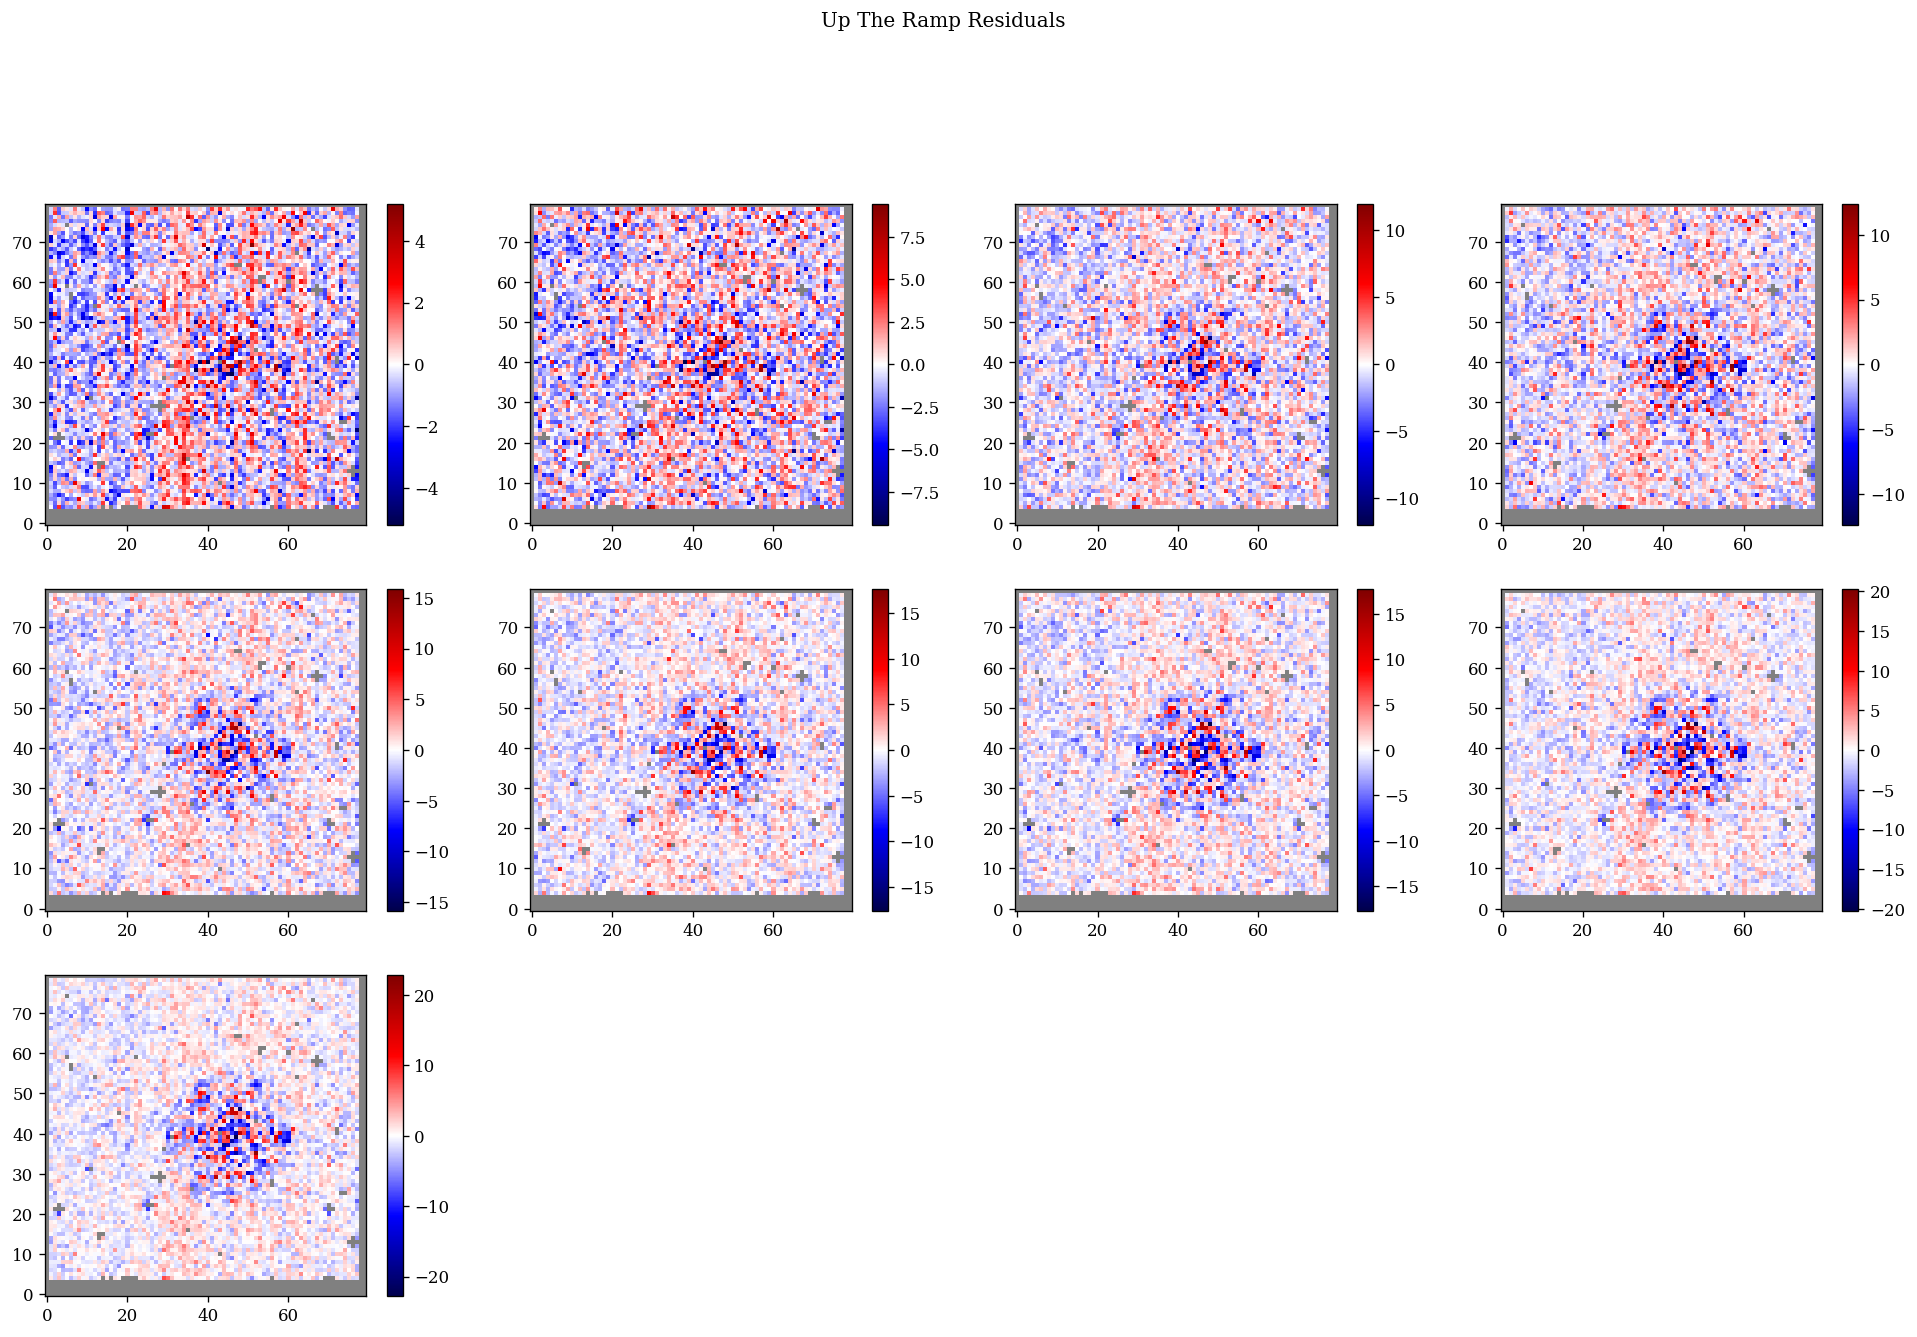

Exposure: HD-36805_F480M_018_02_1
Star: HD-36805
Filter: F480M
N ints: 65


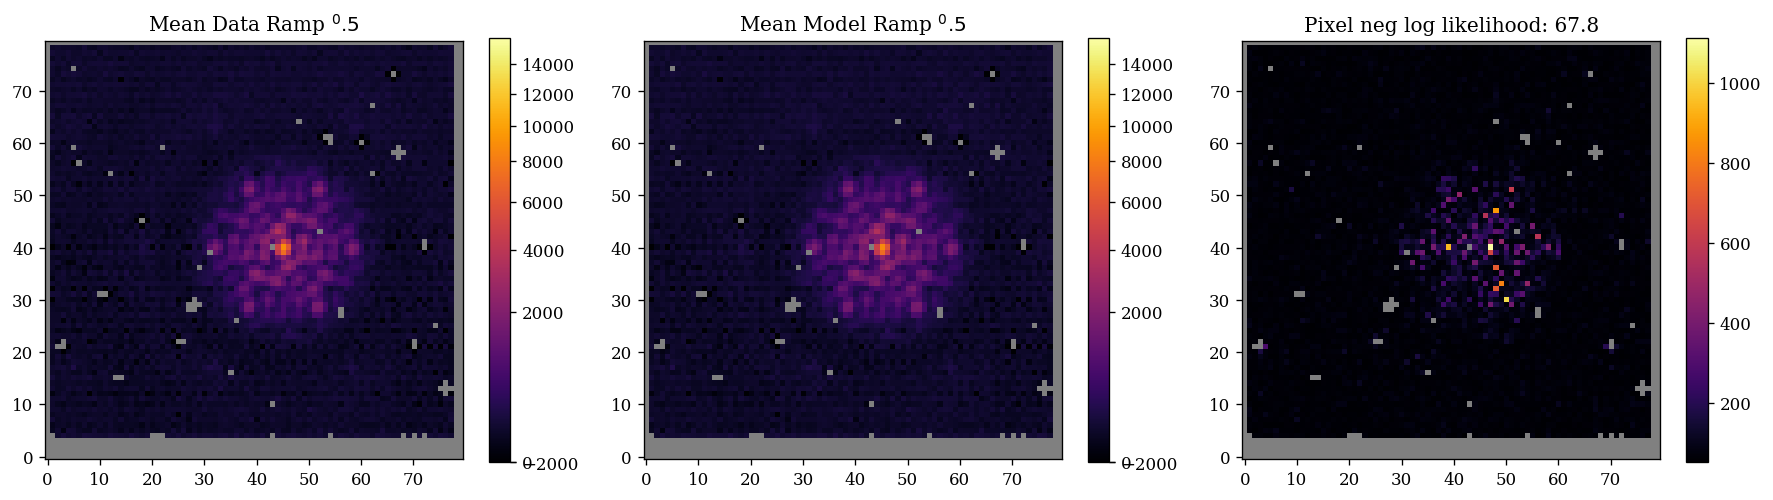

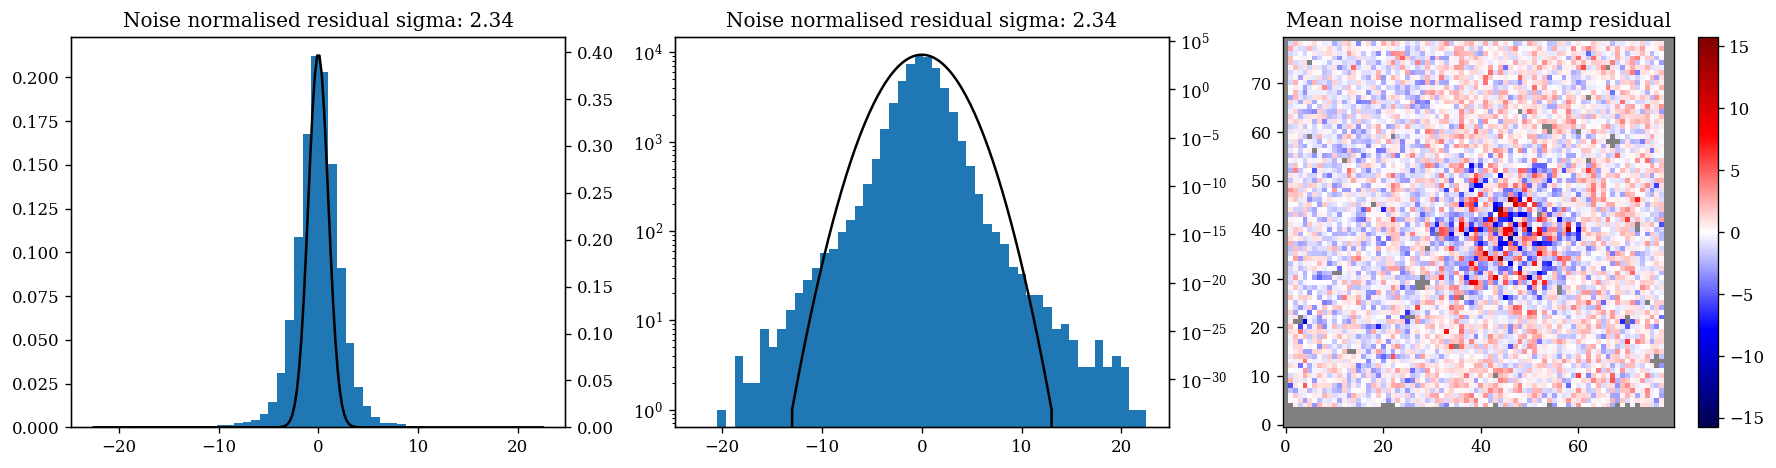

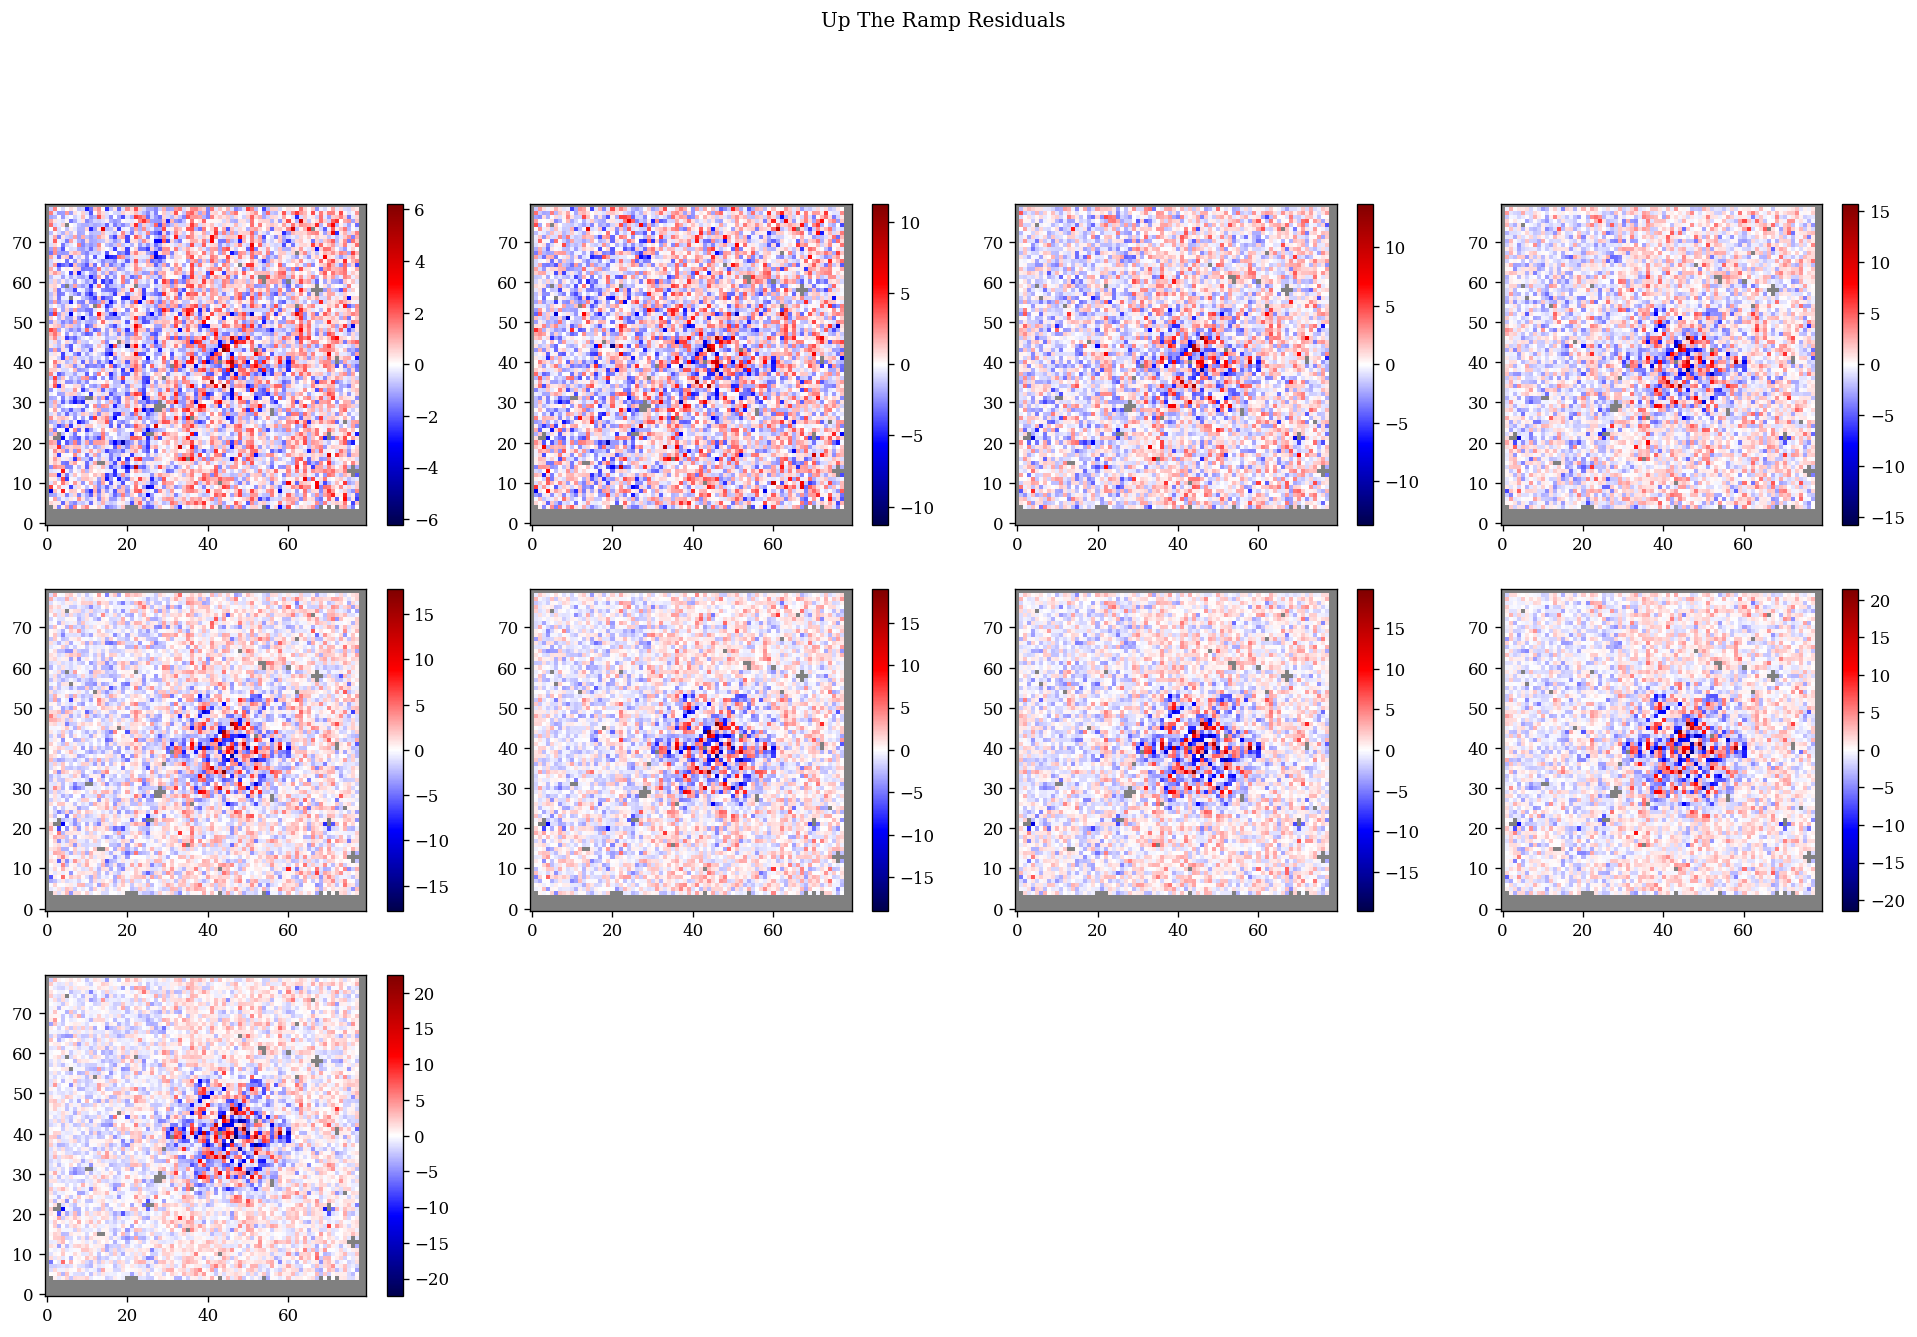

Exposure: HD-116084_F380M_012_02_1
Star: HD-116084
Filter: F380M
N ints: 10000


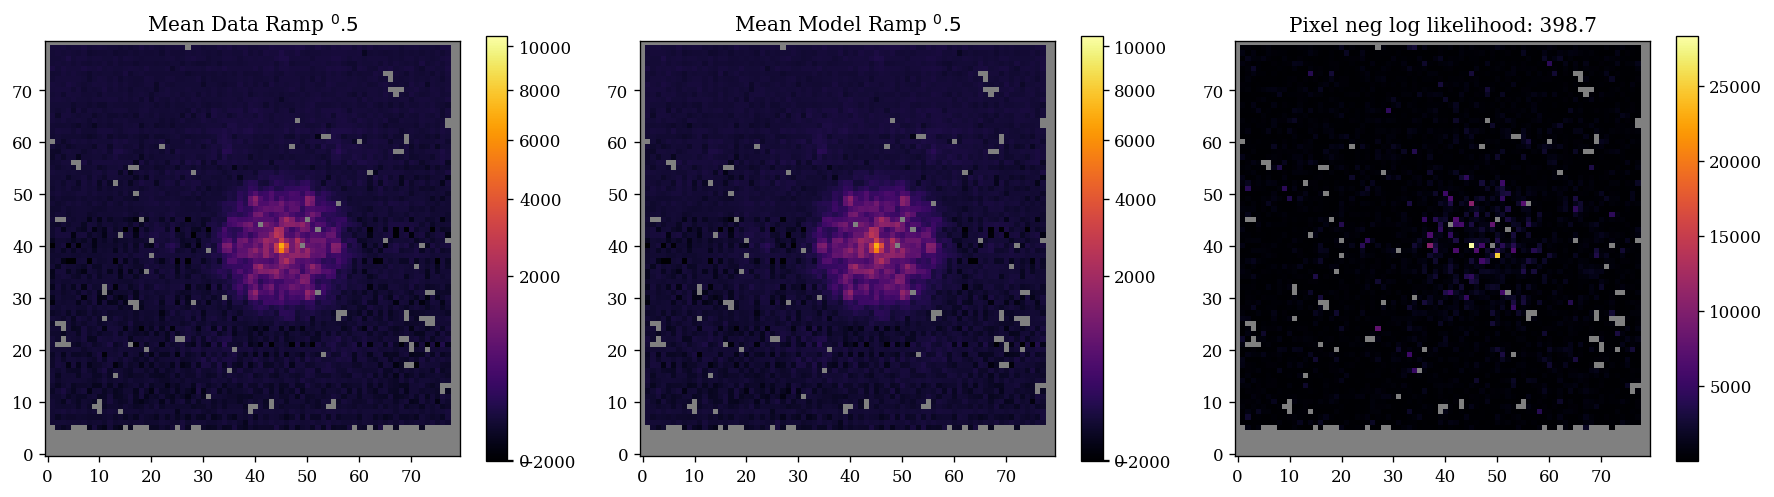

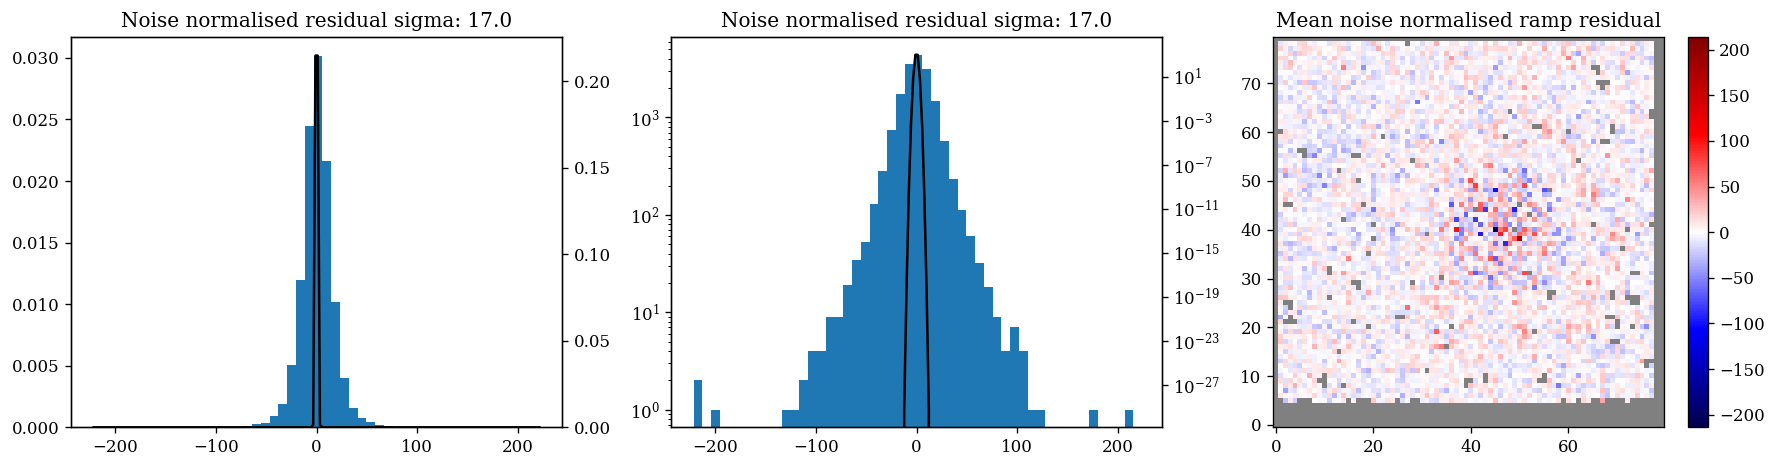

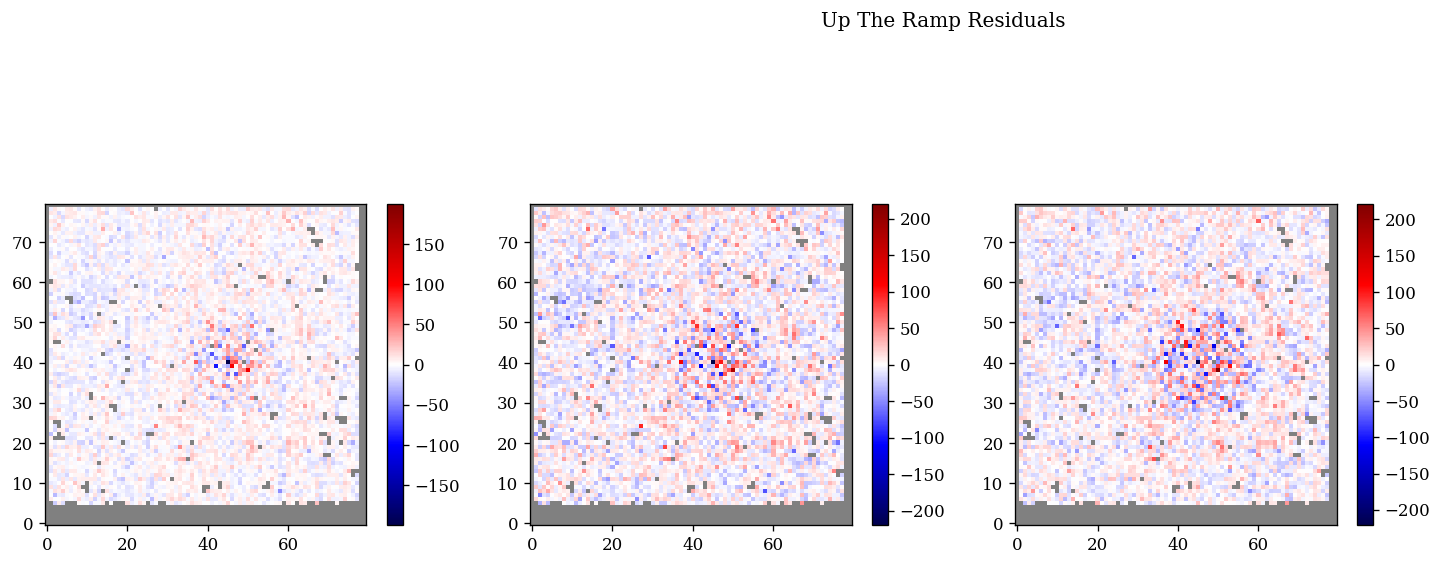

Exposure: HD-116084_F380M_012_03_1
Star: HD-116084
Filter: F380M
N ints: 6000


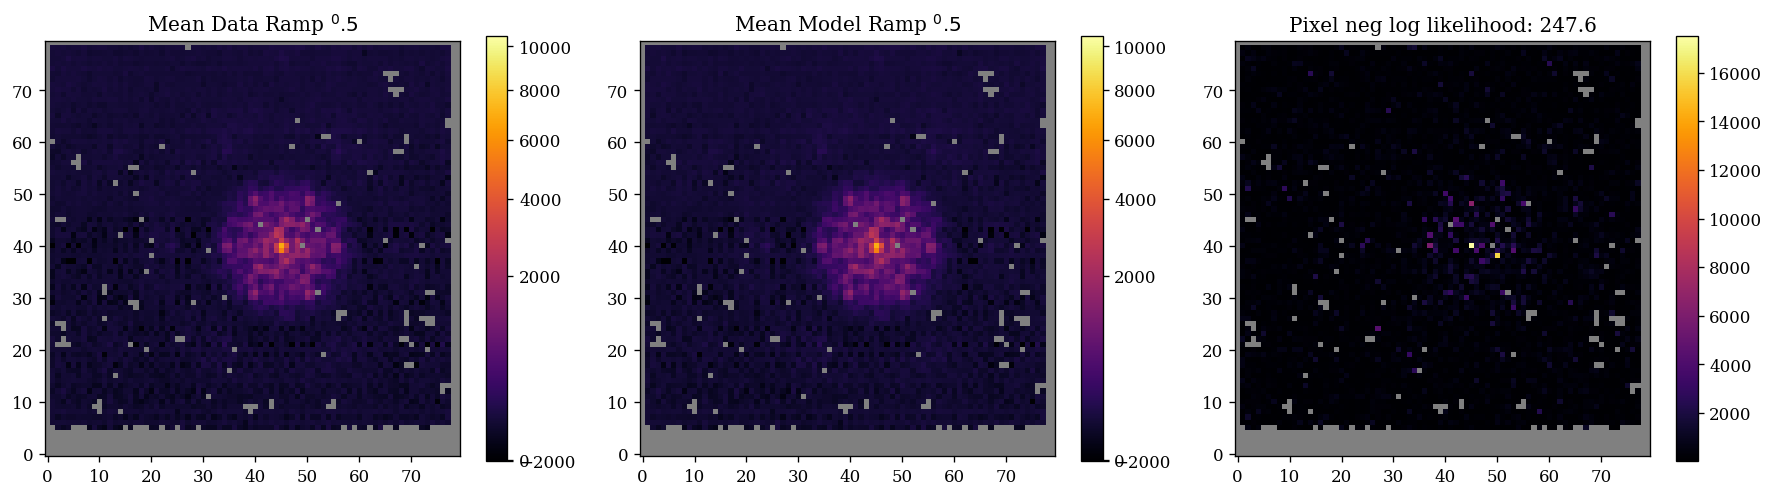

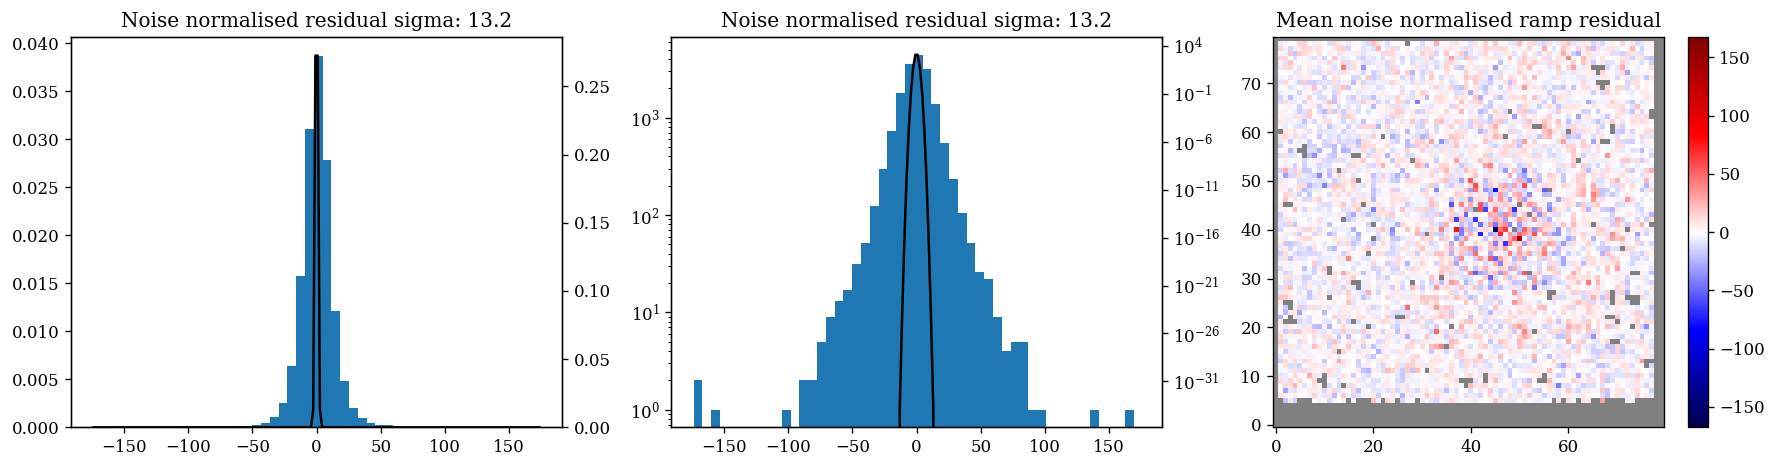

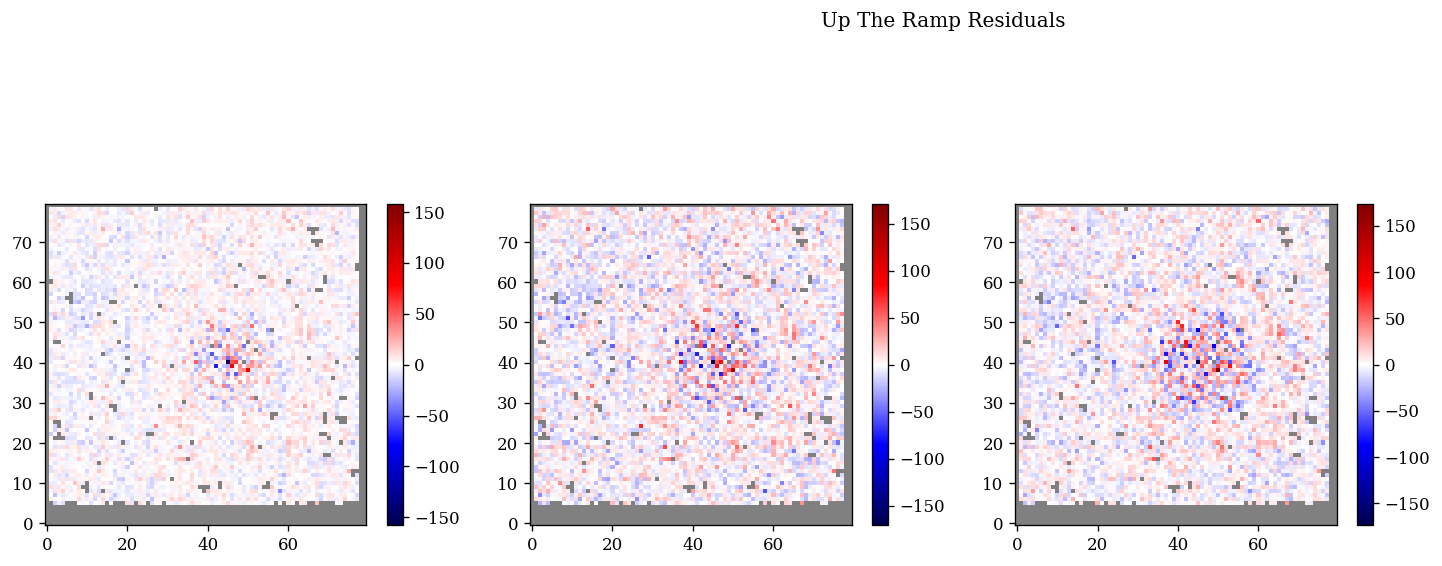

Exposure: HD-115842_F380M_010_02_1
Star: HD-115842
Filter: F380M
N ints: 10000


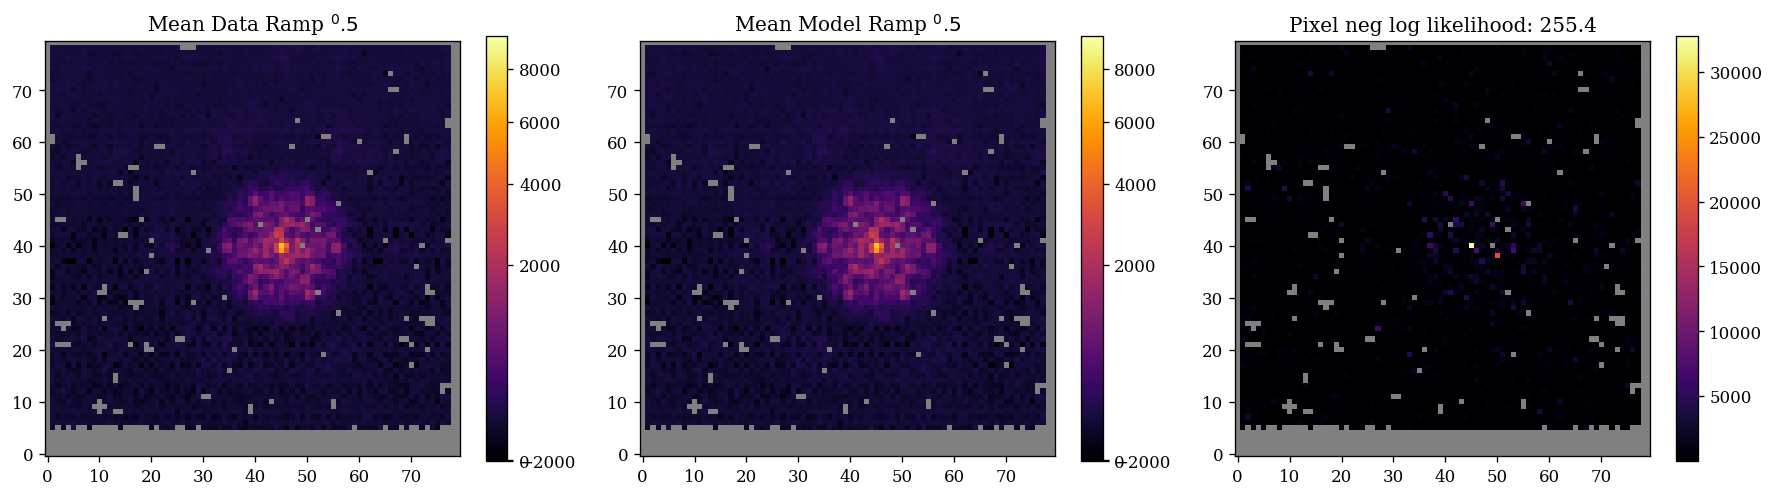

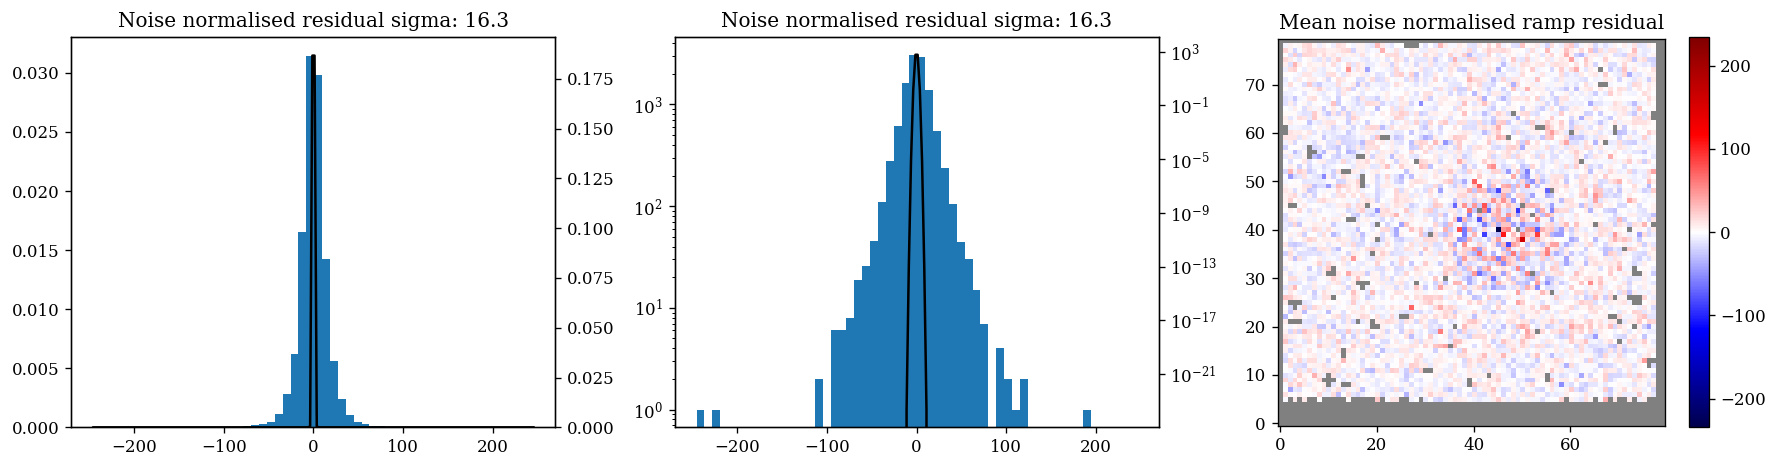

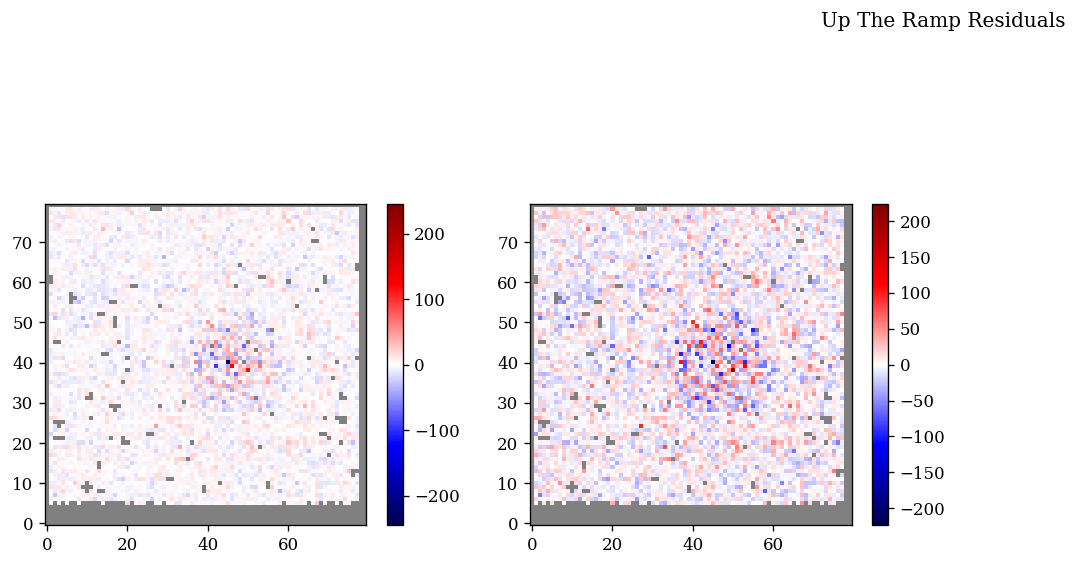

Exposure: HD-115842_F380M_010_03_1
Star: HD-115842
Filter: F380M
N ints: 5500


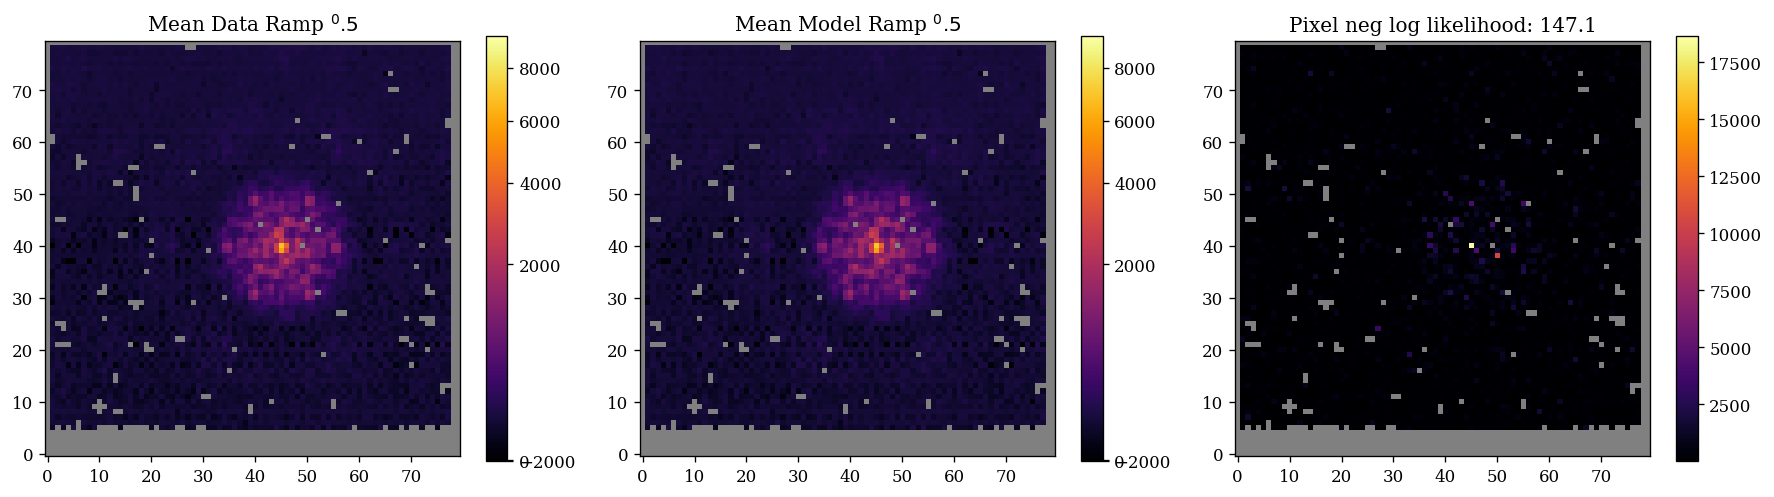

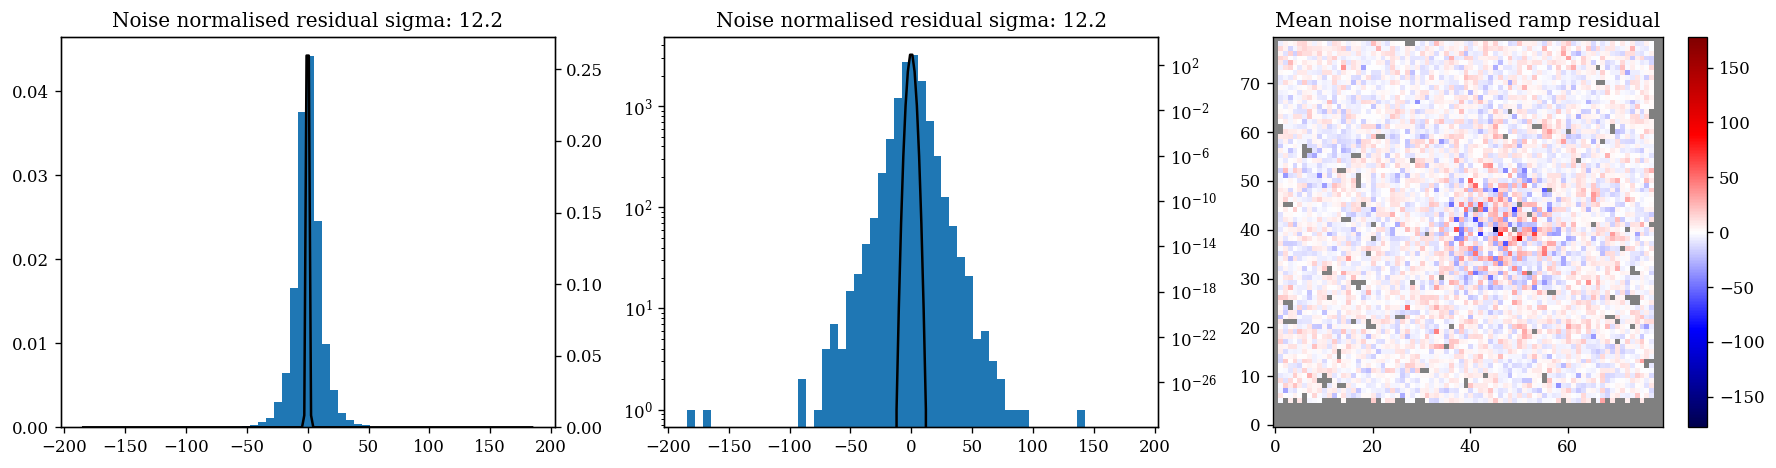

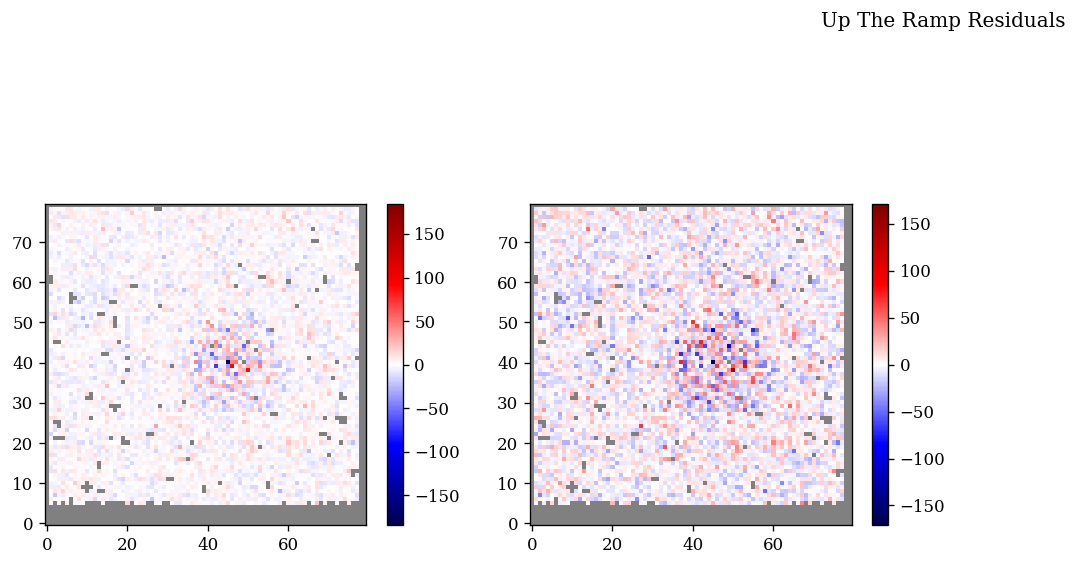

In [24]:
summarise(
    final_model, exposures, up_the_ramp_norm=True, full_bias=False, aberrations=False
    # final_model, exposures, up_the_ramp_norm=True, full_bias=True, aberrations=True
)

In [25]:
# from zodiax.experimental import serialise

# serialise(f"files/reference/convBFE", final_model.BFE)
# serialise(f"files/reference/conv_AMI_mask", final_model.pupil_mask)
# serialise(f"files/reference/conv_params_out", params_out)

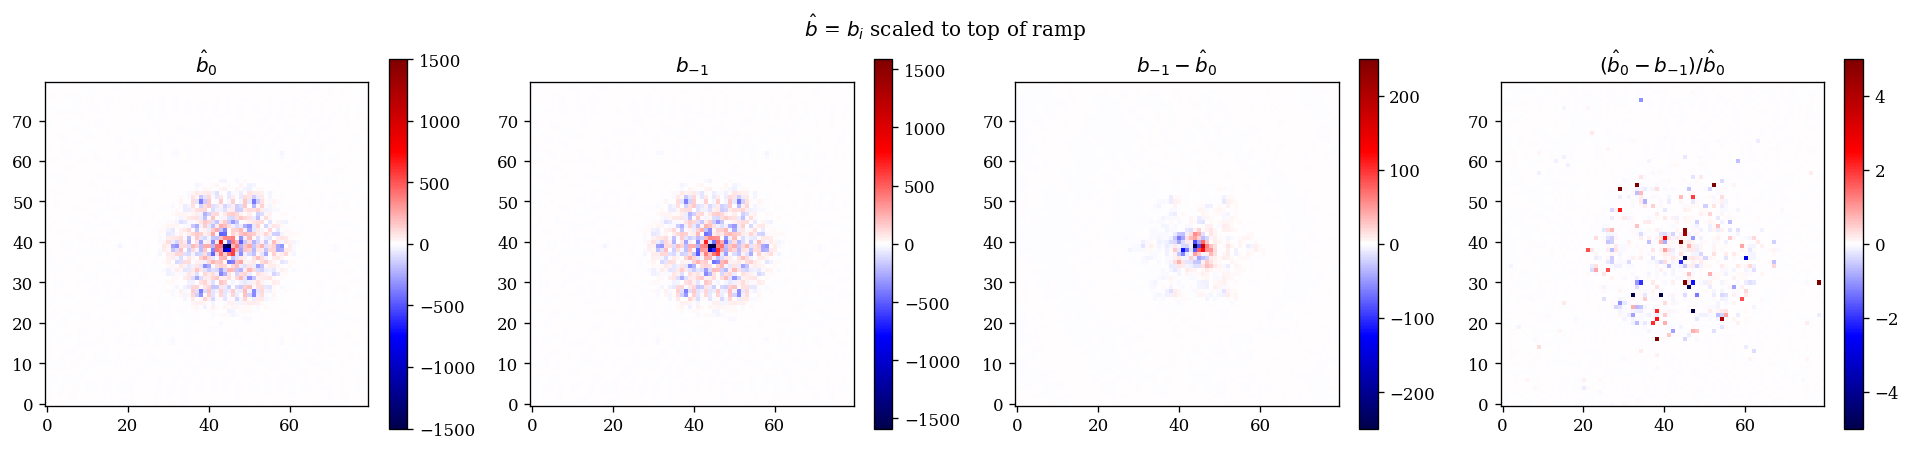

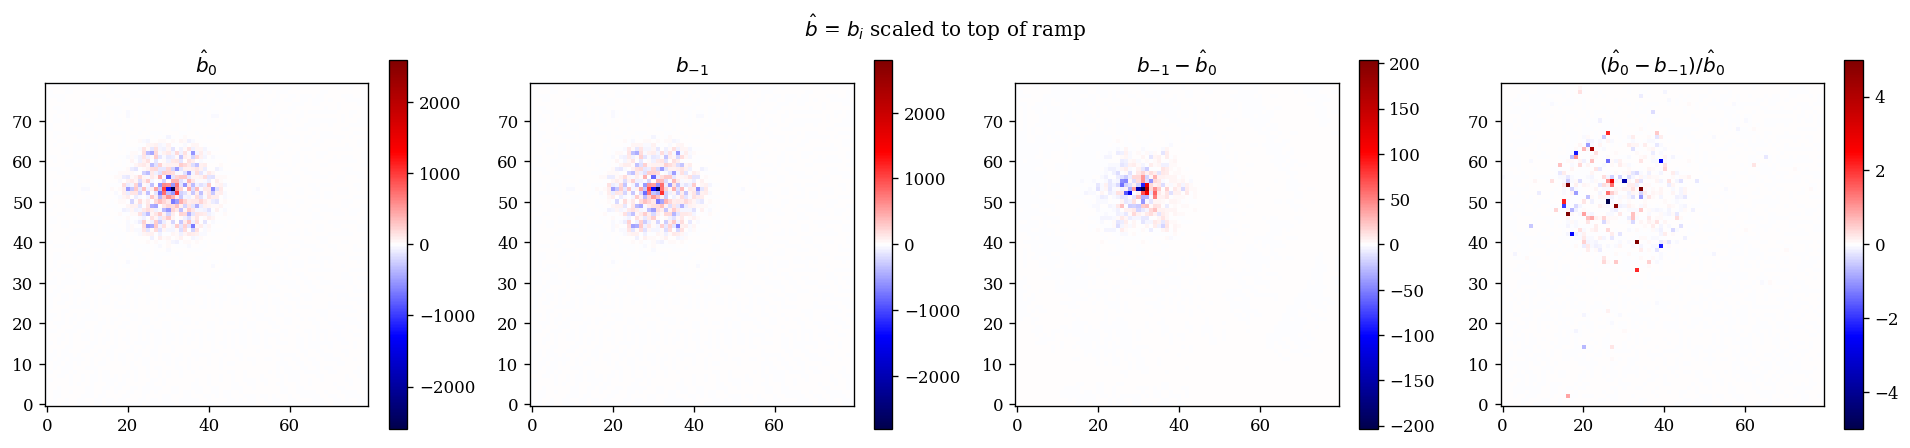

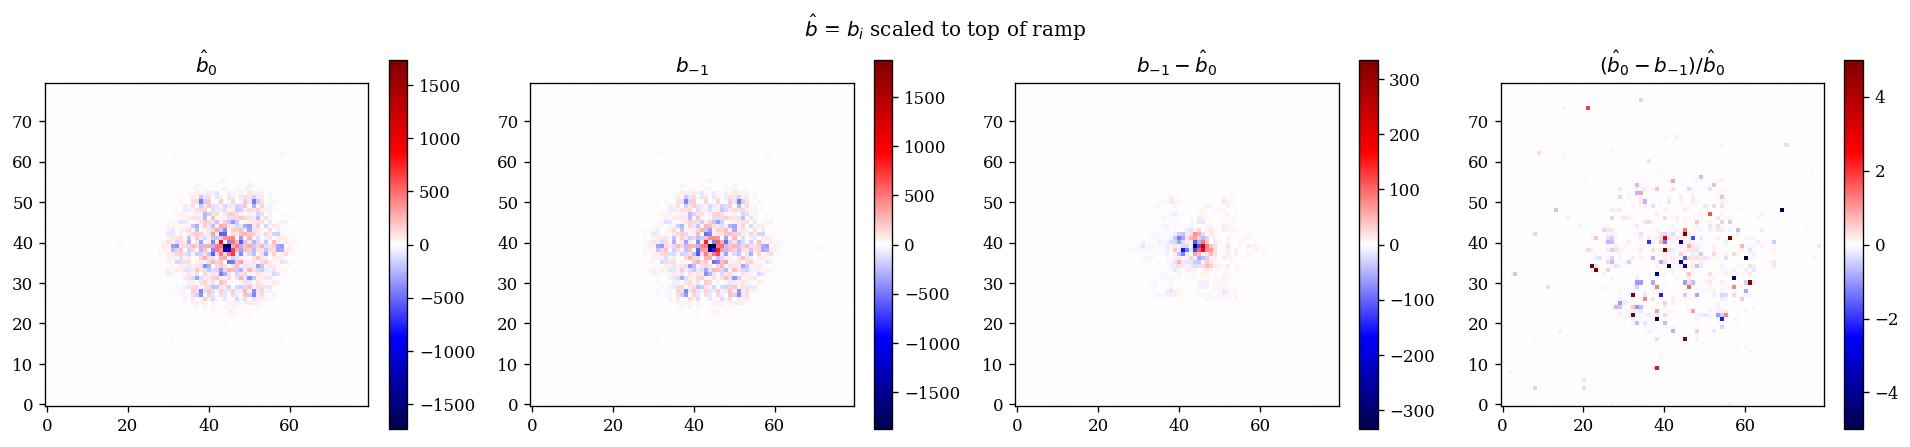

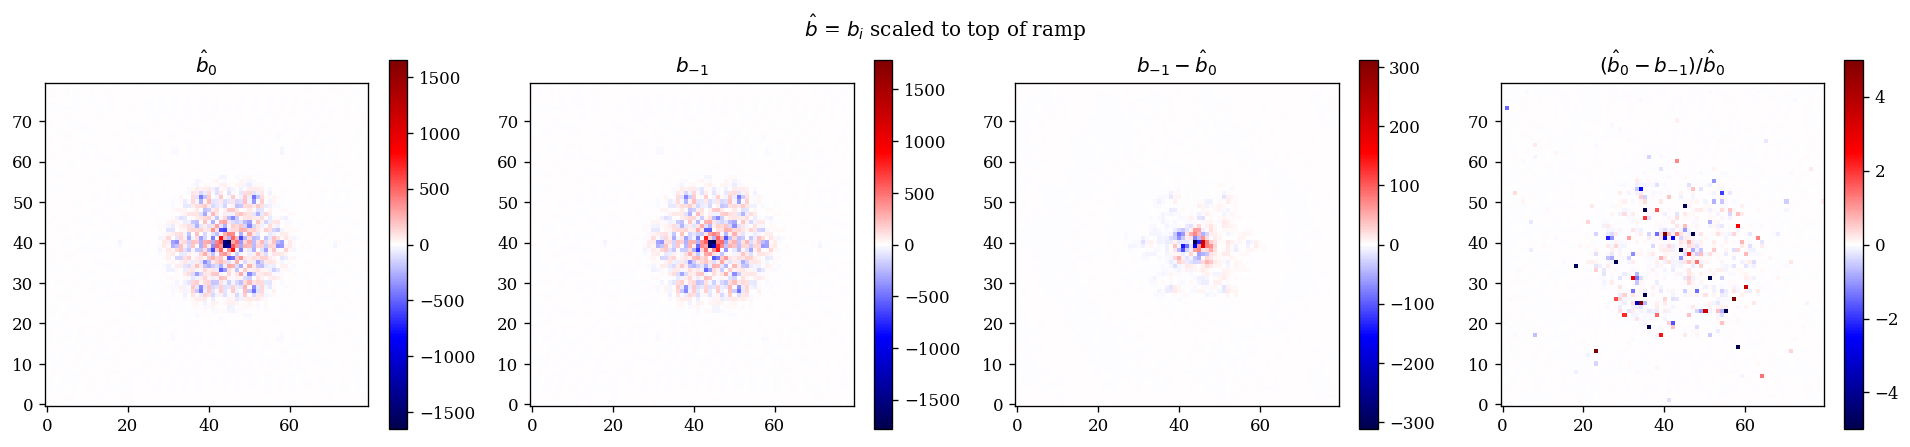

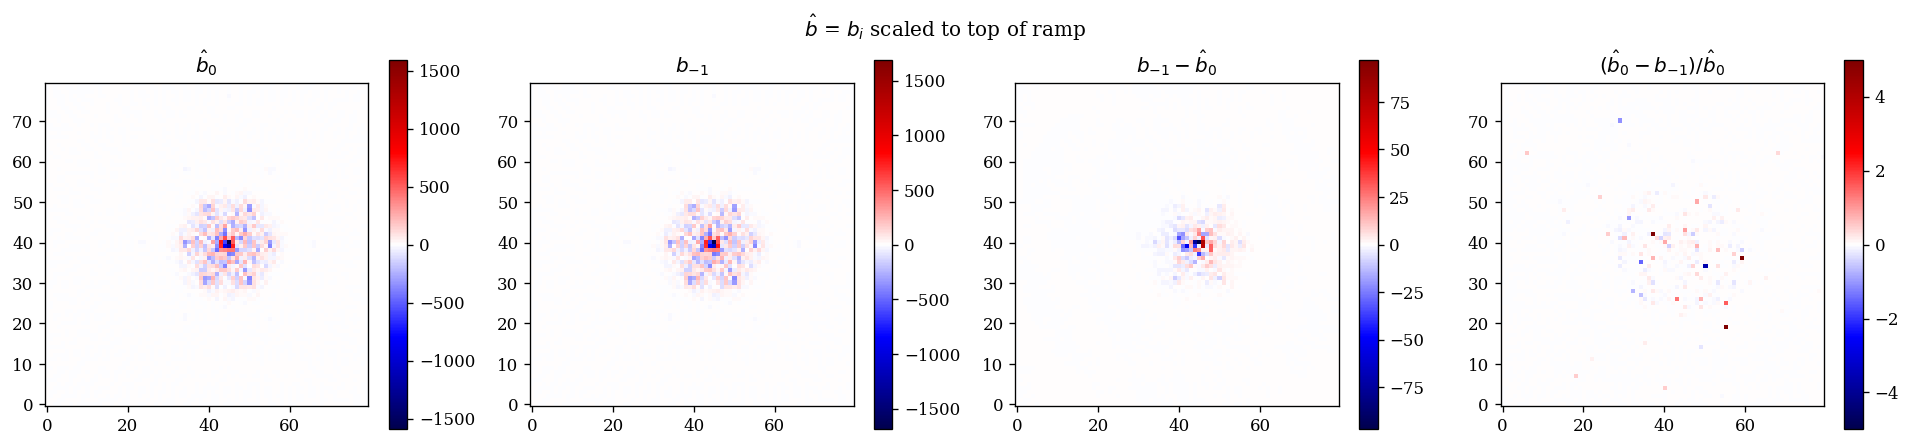

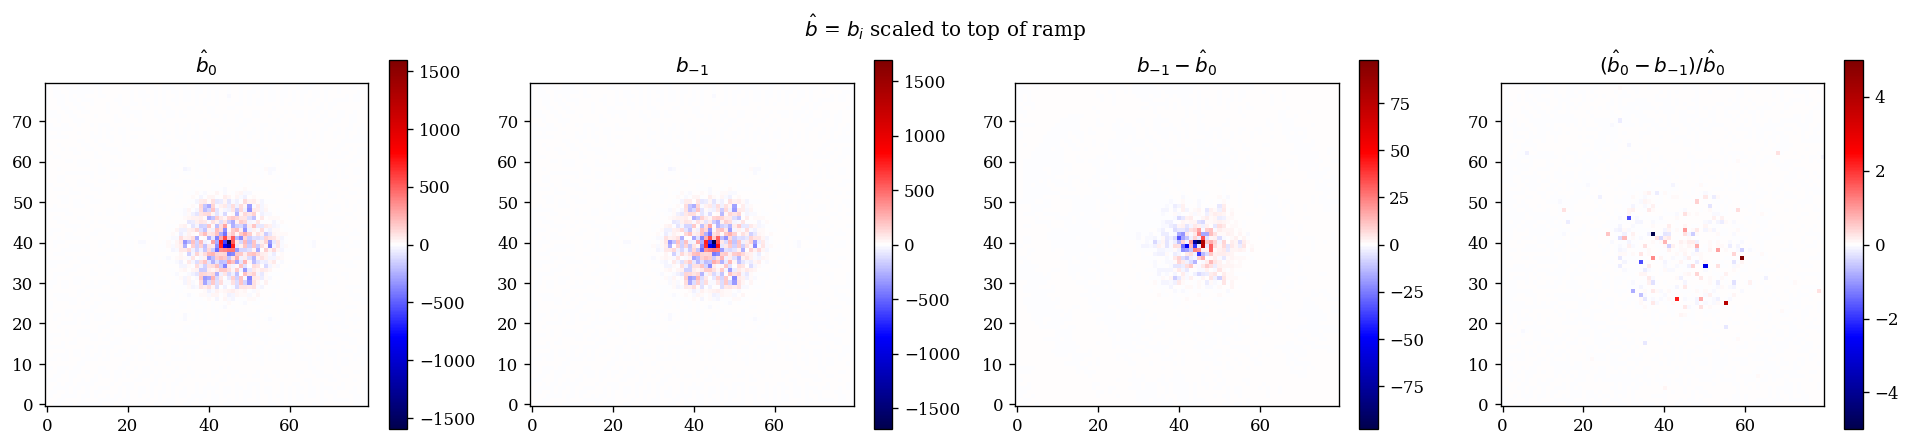

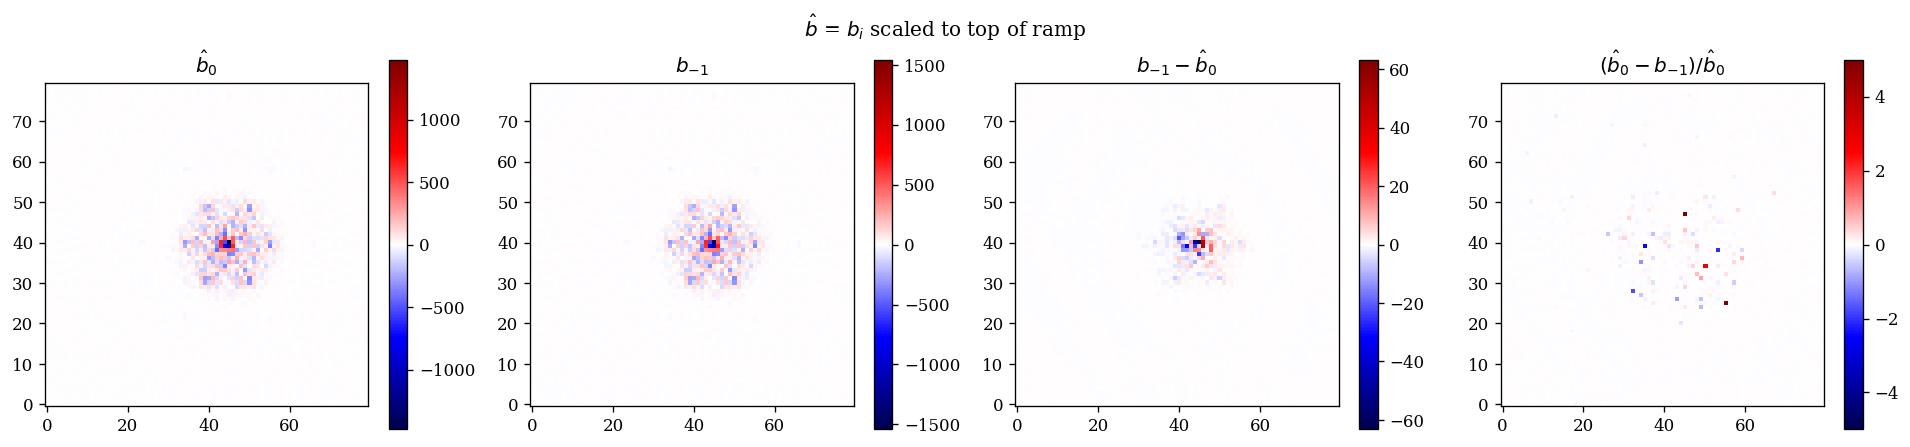

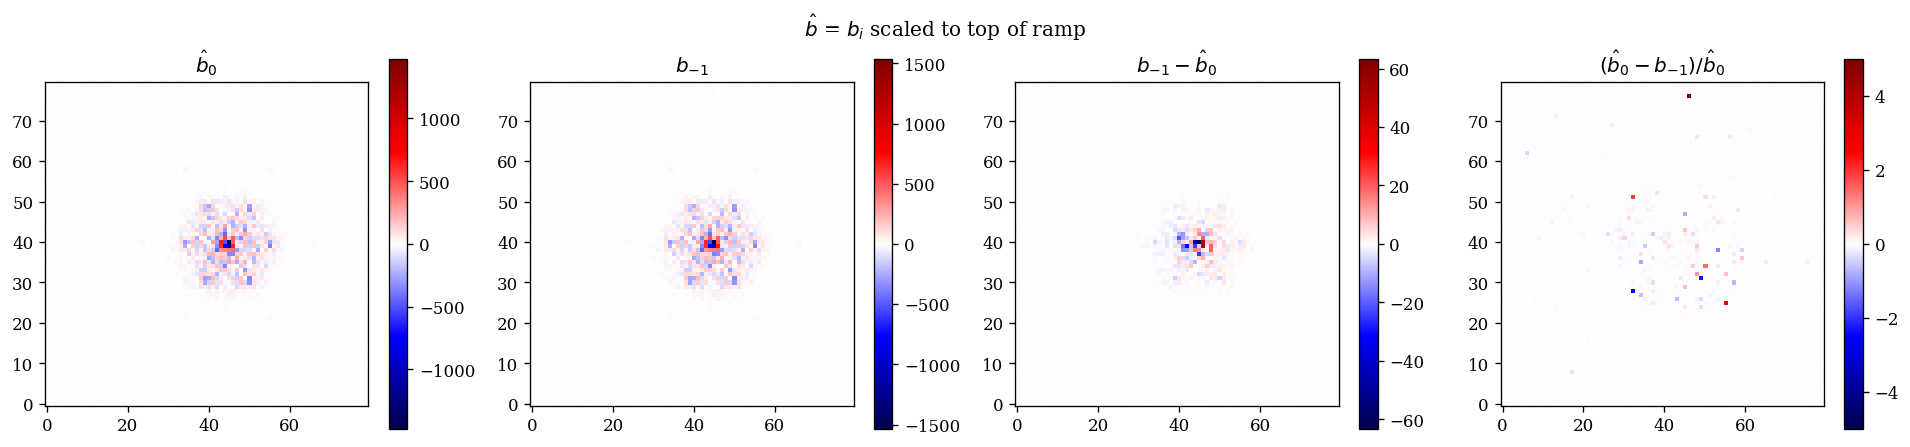

In [26]:
k = (model.optics.psf_npixels - 80) // 2

for i in range(len(ramps)):
    ngroups = len(ramps[i])
    fluxes = (np.arange(ngroups) + 1) / ngroups
    ramp = ramps[i]

    ramp0 = ramp[0]
    ramp1 = ramp[-1]

    psf0 = dlu.downsample(ramp0, oversample, mean=False)[k:-k, k:-k]
    # psf0 = ramp0[k:-k, k:-k]
    final0 = final_model.BFE.apply_array(ramp0)[k:-k, k:-k]
    bleeding0 = final0 - psf0

    psf1 = dlu.downsample(ramp1, oversample, mean=False)[k:-k, k:-k]
    # psf1 = ramp1[k:-k, k:-k]
    final1 = final_model.BFE.apply_array(ramp1)[k:-k, k:-k]
    bleeding1 = final1 - psf1

    ramp_vals = (np.arange(ngroups) + 1) / ngroups
    inv_ramp = 1 / ramp_vals

    inv_ramp0 = inv_ramp[0]
    inv_ramp1 = inv_ramp[-1]

    bleed0_norm = bleeding0 * inv_ramp0
    bleed1_norm = bleeding1 * inv_ramp1

    plt.figure(figsize=(20, 4))
    plt.suptitle("$\\hat{b}$ = $b_{i}$ scaled to top of ramp")
    plt.subplot(1, 4, 1)
    plt.title("$\\hat{b}_0$")
    v = np.nanmax(np.abs(bleed0_norm))
    plt.imshow(bleed0_norm, cmap=seismic, vmin=-v, vmax=v)
    plt.colorbar()

    plt.subplot(1, 4, 2)
    plt.title("$b_{-1}$")
    v = np.nanmax(np.abs(bleed1_norm))
    plt.imshow(bleed1_norm, cmap=seismic, vmin=-v, vmax=v)
    plt.colorbar()

    plt.subplot(1, 4, 3)
    # plt.title("$\\hat{b}_0 - b_{-1}$")
    plt.title("$b_{-1} - \\hat{b}_0$")

    # res = bleed0_norm - bleed1_norm
    res = bleed1_norm - bleed0_norm
    v = np.nanmax(np.abs(res))
    plt.imshow(res, cmap=seismic, vmin=-v, vmax=v)
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.title("$(\\hat{b}_0 - b_{-1}) / \\hat{b}_0$")
    res_norm = res / bleed0_norm
    v = np.minimum(np.nanmax(np.abs(res_norm)), 5)
    plt.imshow(res_norm, cmap=seismic, vmin=-v, vmax=v)
    plt.colorbar()

    plt.show()